************************************************************************************************************************************************************************************************************************************************************************************************************


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Date
2021-08-03    419.371033
2021-08-04    417.308258
2021-08-05    419.950928
2021-08-06    420.644928
2021-08-09    420.302734
                 ...    
2024-12-27    595.010010
2024-12-30    588.219971
2024-12-31    586.080017
2025-01-02    584.640015
2025-01-03    591.950012
Name: SPY_Adj_Close, Length: 861, dtype: float64
************************************************************************************************************************************************************************************************************************************************************************************************************
Fetching SPY data...
Processing data...
Training model...
Epoch 1/200



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0249 - val_loss: 0.0145
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0087
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0213
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0054
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_l

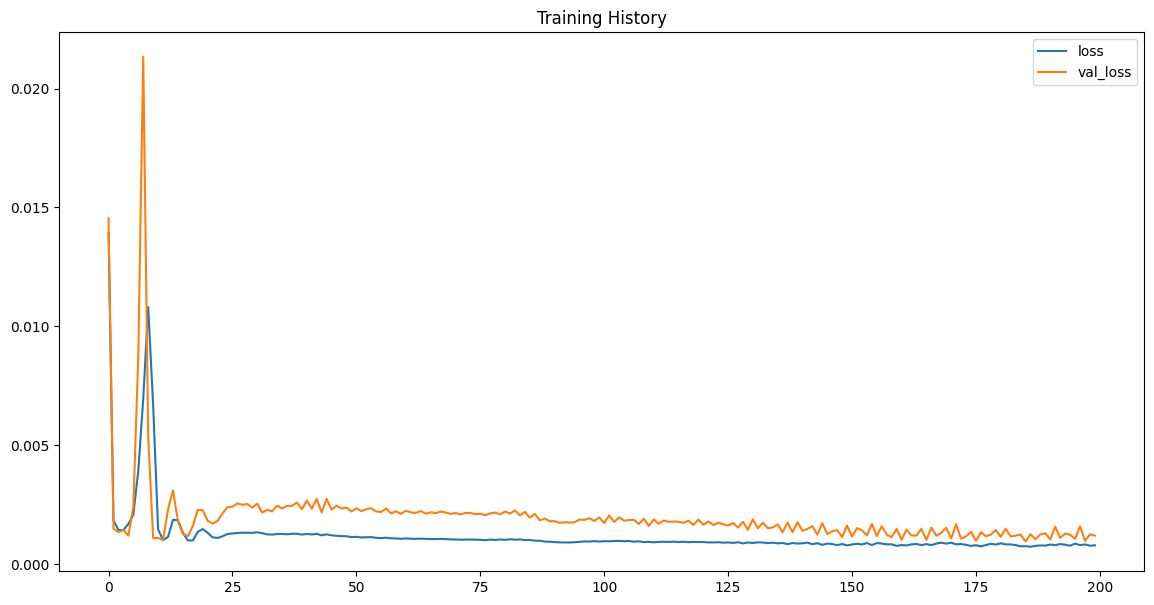

Generating predictions and analysis...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


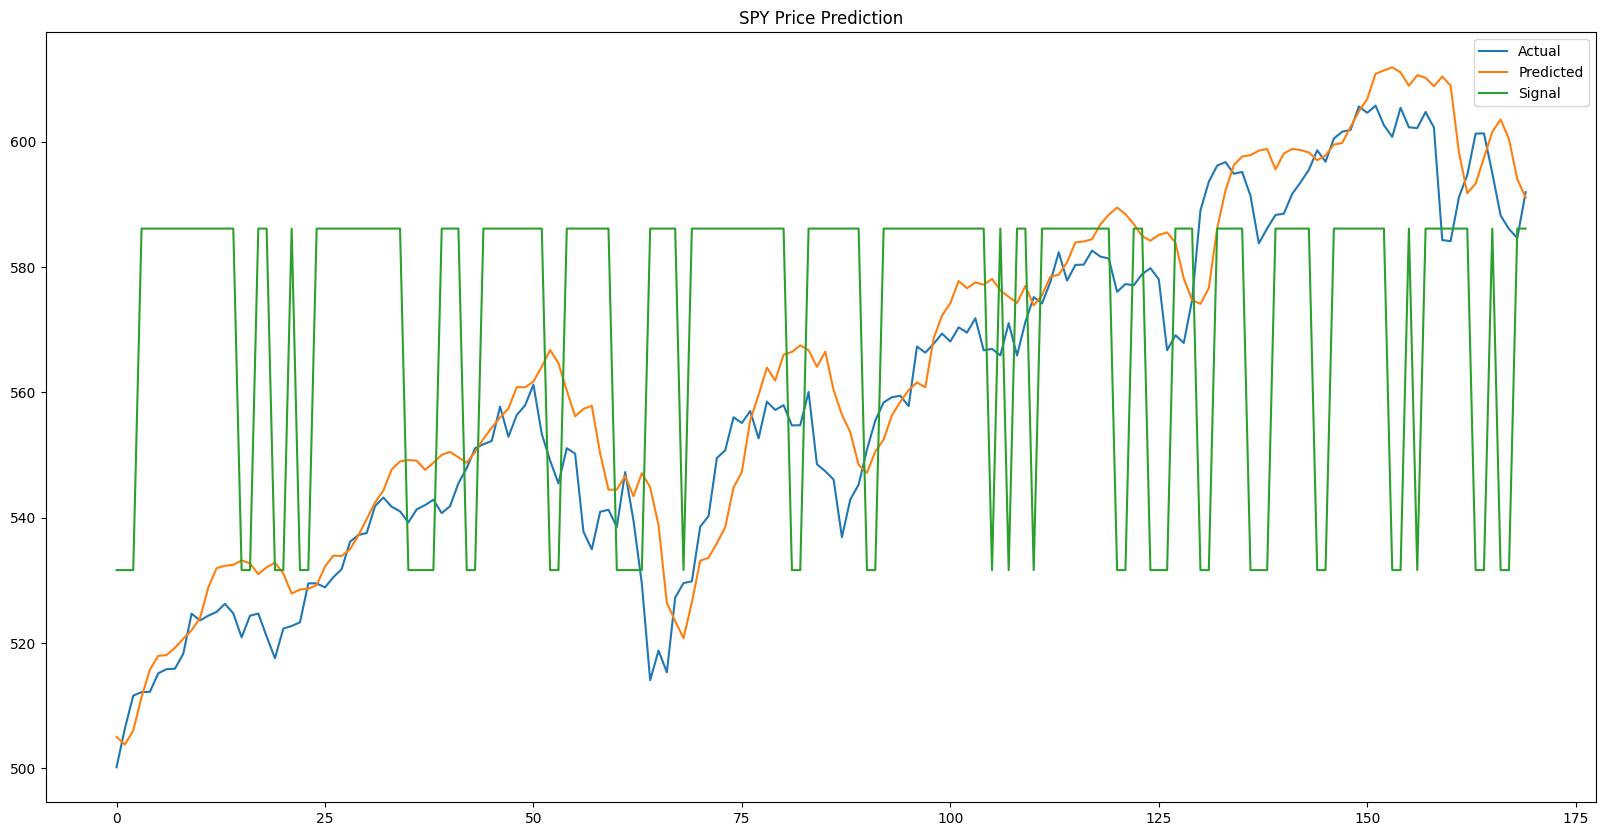


Last 5 actual values:
165    595.010010
166    588.219971
167    586.080017
168    584.640015
169    591.950012
dtype: float64

Last 5 predicted values:
165    601.560791
166    603.557556
167    600.428101
168    594.008484
169    591.120239
dtype: float32
Model saved to spy_predictor_model.keras


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

class SPYPredictor:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler()
    def process_data(self, data, lookback=14, gap=1):
          """Process data into sequences for the CNN"""
          # Scale the data
          scaled_data = self.scaler.fit_transform(data.values.reshape(-1, 1))

          X, Y = [], []
          for i in range(len(scaled_data) - lookback - gap):
              X.append(scaled_data[i:(i + lookback), 0])
              Y.append(scaled_data[(i + lookback + gap), 0])

          X = np.array(X)
          Y = np.array(Y)

          # Split into train/test
          train_size = int(X.shape[0] * 0.80)
          X_train, X_test = X[:train_size], X[train_size:]
          y_train, y_test = Y[:train_size], Y[train_size:]

          # Reshape for CNN
          X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
          X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

          return X_train, X_test, y_train, y_test
    def build_model(self, input_shape):
        """Build the CNN model"""
        model = Sequential([
            Conv1D(5, 1, strides=1, activation='relu', input_shape=input_shape),
            Flatten(),
            Dense(120, activation='relu'),
            Dense(1, activation='relu')
        ])

        model.compile(optimizer='adam', loss='mse')
        return model
    def train(self, X_train, y_train, X_test, y_test, epochs=200):
        """Train the model"""
        self.model = self.build_model((X_train.shape[1], 1))

        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            shuffle=False,
            verbose=1
        )

        return history.history

    def predict_and_analyze(self, X_test, y_test):
        """Make predictions and generate analysis"""
        predictions = self.model.predict(X_test)

        # Inverse transform the scaled values
        y_actual = pd.Series(self.scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1))
        y_pred = pd.Series(self.scaler.inverse_transform(predictions).reshape(-1))

        # Calculate signals
        y_ema = y_actual.ewm(span=3).mean()
        signal = pd.Series(index=y_actual.index, data=np.zeros(y_actual.size))
        pred_diff = y_pred.diff(3)
        actual_diff = y_ema.diff(3)

        # Generate trading signals
        for i in y_actual.index:
            if (pred_diff[i] > 0 and actual_diff[i] > 0) or (pred_diff[i] < 0 and actual_diff[i] < 0):
                signal[i] = y_actual.mean() + y_actual.std()
            else:
                signal[i] = y_actual.mean() - y_actual.std()

        return y_actual, y_pred, signal


    def save_model(self, filepath='spy_predictor_model.keras'):
        """Save the trained model to a file"""
        if self.model is not None:
            self.model.save(filepath)
            print(f"Model saved to {filepath}")
        else:
            print("No model to save. Please train the model first.")

    def fetch_data(self, lookback_days=1250):
        """
        Fetch SPY data from yFinance and return a flattened pandas Series of adjusted close prices.

        Args:
            lookback_days (int): Number of days to look back for data.

        Returns:
            pd.Series: A Series containing the adjusted close prices.
        """
        try:
            # Define date range
            end_date = datetime.now()
            start_date = end_date - timedelta(days=lookback_days)

            # Fetch data using yfinance
            spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

            # Check if data is retrieved successfully
            if spy_data.empty:
                print("No data retrieved for the specified date range.")
                return pd.Series()

            # Extract 'Adj Close' column
            adj_close_data = spy_data['Adj Close']

            # Debugging output (optional)
            """print("//////" * 10)
            print("Raw Adjusted Close Data:")
            print(adj_close_data)
            print("//////" * 10)"""

            # Convert to a NumPy array and then to a pandas Series
            flattened_data = np.array(adj_close_data).reshape(-1)

            # Return as a pandas Series
            return pd.Series(data=flattened_data, index=adj_close_data.index, name="SPY_Adj_Close")

        except Exception as e:
            print(f"An error occurred: {e}")
            return pd.Series()

predictor = SPYPredictor()
print("******"*50)
print(predictor.fetch_data())
print("******"*50)
def main():
    # Initialize predictor
    predictor = SPYPredictor()

    # Fetch data
    print("Fetching SPY data...")
    data = predictor.fetch_data()

    # Process data
    print("Processing data...")
    X_train, X_test, y_train, y_test = predictor.process_data(data)

    # Train model
    print("Training model...")
    history = predictor.train(X_train, y_train, X_test, y_test)

    # Plot training history
    plt.figure(figsize=(14, 7))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

    # Make predictions and analyze
    print("Generating predictions and analysis...")
    y_actual, y_pred, signal = predictor.predict_and_analyze(X_test, y_test)

    # Plot results
    plt.figure(figsize=(20, 10))
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.plot(signal, label='Signal')
    plt.title('SPY Price Prediction')
    plt.legend()
    plt.show()

    # Print last few predictions
    print("\nLast 5 actual values:")
    print(y_actual.tail())
    print("\nLast 5 predicted values:")
    print(y_pred.tail())
    predictor.save_model()

if __name__ == "__main__":
    main()

In [ ]:

file_path = "/content/spy_predictor_model.keras"

SPYModel1 = load_model(file_path)

SPYModel1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

[*********************100%***********************]  1 of 1 completed


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


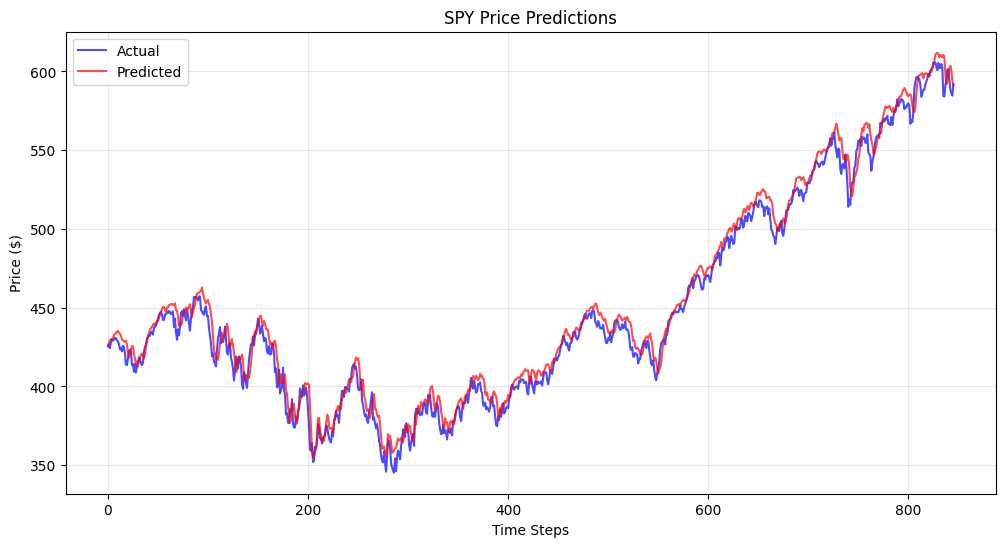


Prediction Statistics:
Mean Squared Error: 63.98
Mean Absolute Error: 6.31


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import matplotlib.pyplot as plt

def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


Starting layer analysis...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Analyzing Original Model:
Layer Information:

Layer 0: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten (Flatten)

Layer 2: dense (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_1 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d

Weight Statistics:
mean: 0.0251
std: 0.4216
min: -0.7210
max: 0.4801
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0208
bias_std: 0.0177
bias_nonzero: 3


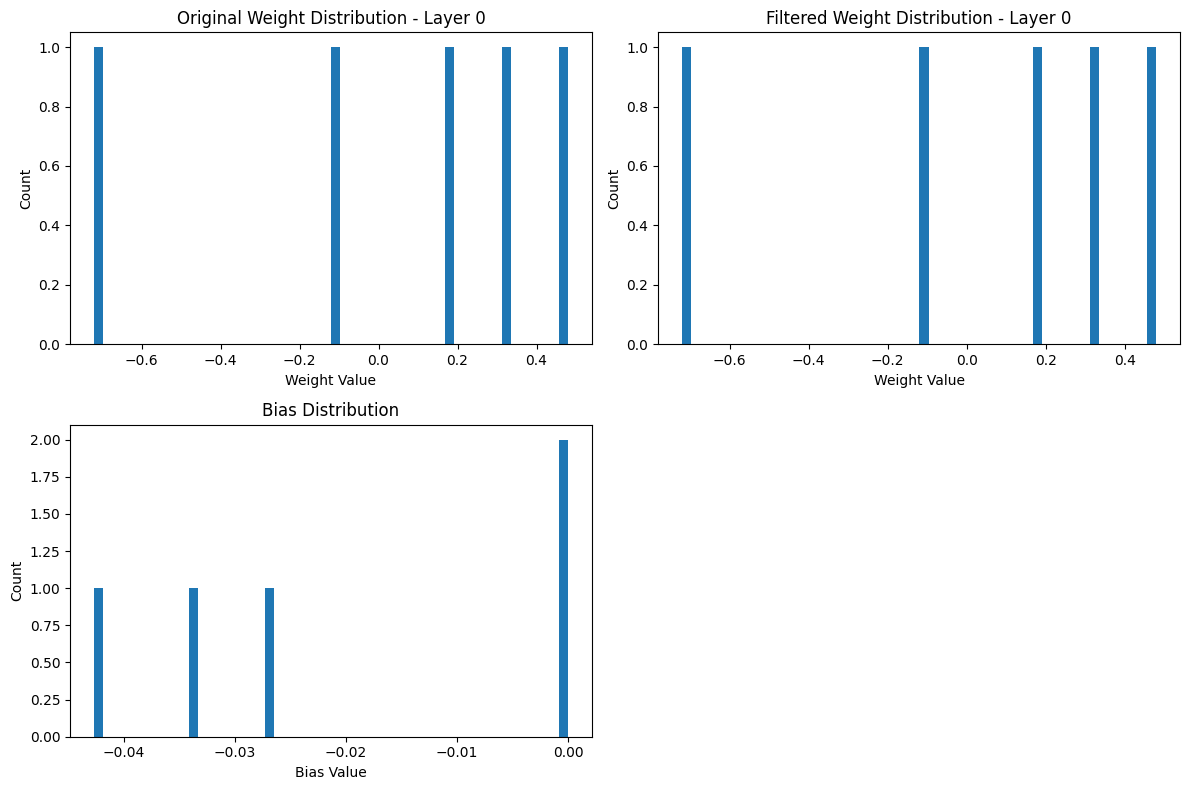


Analyzing Layer 2: dense

Weight Statistics:
mean: -0.0046
std: 0.1173
min: -0.8745
max: 0.5444
sparsity: 0.0000
total_weights: 8,400
nonzero_weights: 8,400
bias_mean: -0.0011
bias_std: 0.0184
bias_nonzero: 119


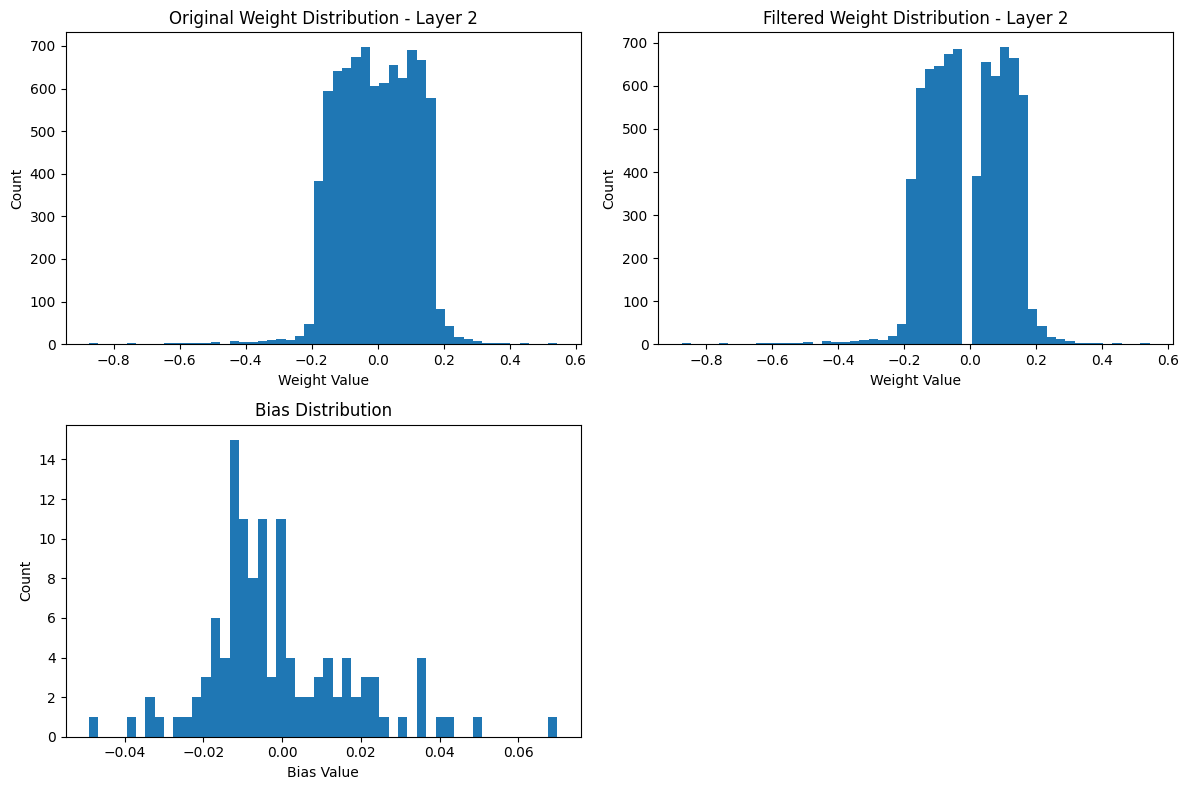


Analyzing Layer 3: dense_1

Weight Statistics:
mean: -0.0363
std: 0.2014
min: -0.7613
max: 1.1543
sparsity: 0.0000
total_weights: 120
nonzero_weights: 120
bias_mean: 0.0367
bias_std: 0.0000
bias_nonzero: 1


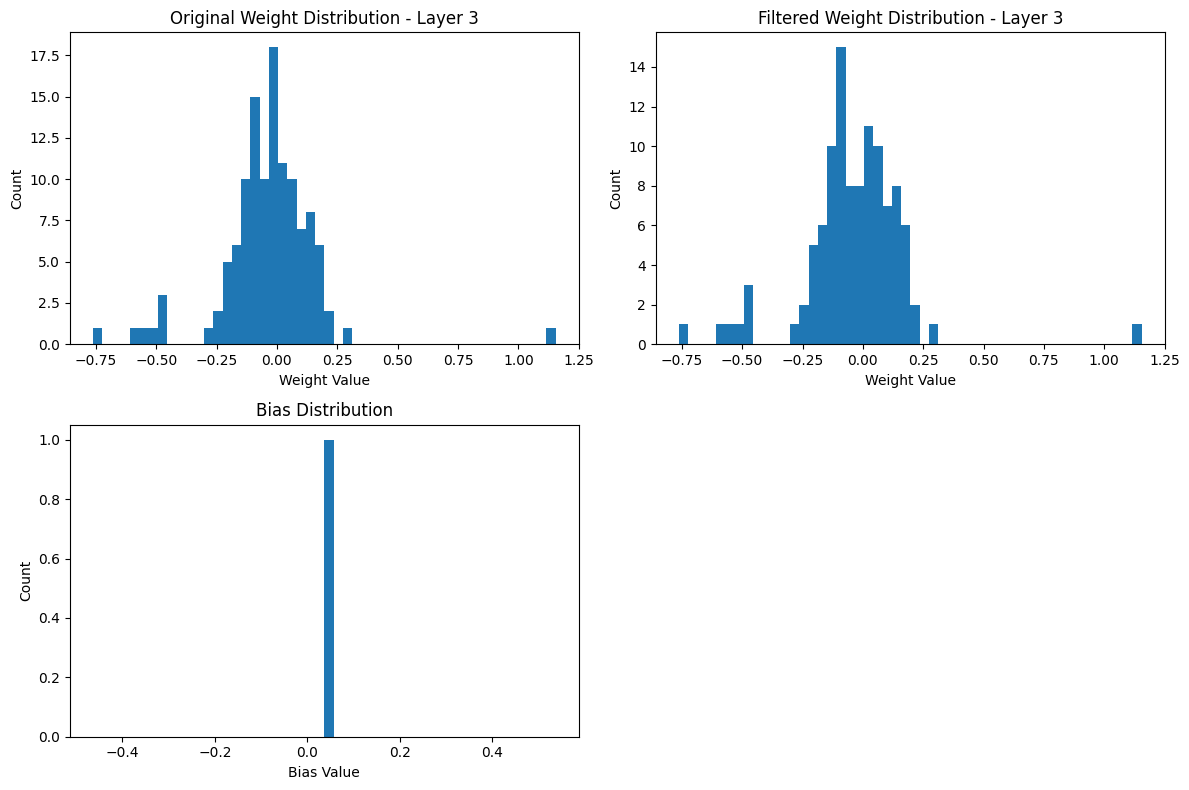

ValueError: Layer conv1d weight shape (5,) is not compatible with provided weight shape (1,).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import tensorflow as tf

class SimpleLayerAnalyzer:
    def __init__(self, model):
        """Initialize analyzer with a trained model"""
        self.model = model
        self.filtered_weights = {}  # Store filtered weights for each layer
        self.non_prunable_layers = {
            "Conv2D", "Flatten", "BatchNormalization", "LayerNormalization", "MaxPooling2D", "AveragePooling2D", "Dropout"
        }

    def print_layer_info(self):
        """Print basic information about each layer"""
        for i, layer in enumerate(self.model.layers):
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            weights = layer.get_weights()
            if weights:
                print(f"Number of weight arrays: {len(weights)}")
                for j, w in enumerate(weights):
                    print(f"Weight array {j} shape: {w.shape}")

    def analyze_weights(self, layer_index: int) -> Dict[str, np.ndarray]:
        """Analyze weights of a specific layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()

        if not weights:
            return {}

        analysis = {}

        # Analyze the main weights (usually the first array)
        if len(weights) > 0:
            main_weights = weights[0]
            analysis['mean'] = np.mean(main_weights)
            analysis['std'] = np.std(main_weights)
            analysis['min'] = np.min(main_weights)
            analysis['max'] = np.max(main_weights)
            analysis['sparsity'] = np.mean(main_weights == 0)
            # Count non-zero weights
            analysis['total_weights'] = main_weights.size
            analysis['nonzero_weights'] = np.count_nonzero(main_weights)

        # Analyze bias if present (usually the second array)
        if len(weights) > 1:
            bias = weights[1]
            analysis['bias_mean'] = np.mean(bias)
            analysis['bias_std'] = np.std(bias)
            analysis['bias_nonzero'] = np.count_nonzero(bias)

        return analysis



    def filter_weights(self, layer_index: int, stats: Dict[str, float]) -> List[np.ndarray]:
        """Filter weights while preserving original tensor shapes."""
        layer = self.model.layers[layer_index]
        layer_type = layer.__class__.__name__
        weights = layer.get_weights()

        # Skip layers that should not be altered
        if not weights or layer_type in self.non_prunable_layers:
            print(f"Skipping layer {layer_index}: {layer.name} ({layer_type})")
            return []

        filtered = []
        main_weights = weights[0]
        original_shape = main_weights.shape

        # Flatten weights for filtering
        flattened_weights = main_weights.flatten()

        # Calculate percentiles
        lower_percentile = np.percentile(flattened_weights, 45)
        upper_percentile = np.percentile(flattened_weights, 55)

        # Create masks for filtering
        bottom_mask = (flattened_weights <= lower_percentile)
        top_mask = (flattened_weights > upper_percentile)
        combined_mask = bottom_mask | top_mask

        # Filter weights
        filtered_weights = flattened_weights[combined_mask]

        # Calculate elements per filter
        elements_per_filter = np.prod(original_shape[1:])
        num_filters = len(filtered_weights) // elements_per_filter

        if num_filters == 0:
            # If we filtered too aggressively, keep at least one filter
            num_filters = 1
            filtered_weights = flattened_weights[:elements_per_filter]

        # Reshape filtered weights
        new_shape = (num_filters,) + original_shape[1:]
        filtered_weights = filtered_weights[:num_filters * elements_per_filter].reshape(new_shape)

        filtered.append(filtered_weights)

        # Keep bias if present
        if len(weights) > 1:
            bias = weights[1]
            # Adjust bias to match the number of filters
            filtered.append(bias[:num_filters])

        return filtered
    def plot_weight_distribution(self, layer_index: int):
        """Plot the distribution of weights in a layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        filtered = self.filtered_weights.get(layer_index, None)

        if not weights:
            print(f"Layer {layer_index} ({layer.name}) has no weights to plot")
            return

        plt.figure(figsize=(12, 8))

        # Plot original weights
        plt.subplot(2, 2, 1)
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f'Original Weight Distribution - Layer {layer_index}')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')

        # Plot filtered weights if available
        if filtered is not None:
            plt.subplot(2, 2, 2)
            plt.hist(filtered[0].flatten(), bins=50)
            plt.title(f'Filtered Weight Distribution - Layer {layer_index}')
            plt.xlabel('Weight Value')
            plt.ylabel('Count')

        # Plot bias if present
        if len(weights) > 1:
            plt.subplot(2, 2, 3)
            plt.hist(weights[1].flatten(), bins=50)
            plt.title('Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

def create_filtered_model(original_model, filtered_weights):
    """Create a new model with the same architecture and assign filtered weights"""
    # Create new model with the same architecture
    new_model = tf.keras.models.clone_model(original_model)

    # Compile with same configuration if original model was compiled
    if original_model.optimizer:
        new_model.compile(
            optimizer=original_model.optimizer.__class__(),
            loss=original_model.loss,
            metrics=original_model.metrics
        )

    # Set filtered weights
    for layer_idx, weights in filtered_weights.items():
        if weights:  # Only set weights if we have filtered weights for this layer
            new_model.layers[layer_idx].set_weights(weights)

    return new_model

def analyze_model(model):
    """Helper function to run all analyses and create filtered model"""
    analyzer = SimpleLayerAnalyzer(model)
    filtered_weights = {}

    # Print basic layer information
    print("Layer Information:")
    analyzer.print_layer_info()

    # Analyze each layer
    for i, layer in enumerate(model.layers):
        if layer.get_weights():  # Only analyze layers with weights
            print(f"\nAnalyzing Layer {i}: {layer.name}")

            # Get weight statistics
            stats = analyzer.analyze_weights(i)
            print("\nWeight Statistics:")
            for key, value in stats.items():
                if isinstance(value, (int, np.integer)):
                    print(f"{key}: {value:,}")
                else:
                    print(f"{key}: {value:.4f}")

            # Filter weights
            filtered = analyzer.filter_weights(i, stats)
            if filtered:
                filtered_weights[i] = filtered
                analyzer.filtered_weights[i] = filtered

            # Plot weight distributions
            analyzer.plot_weight_distribution(i)

    return filtered_weights

# Main execution
if __name__ == "__main__":
    # Assuming SPYModel1 is already loaded
    print("\nStarting layer analysis...")
    SPYModel1.summary()

    # Analyze original model and get filtered weights
    print("\nAnalyzing Original Model:")
    filtered_weights = analyze_model(SPYModel1)

    # Create new model with filtered weights
    filtered_model = create_filtered_model(SPYModel1, filtered_weights)
    print("\nFiltered Model Summary:")
    filtered_model.summary()
    filtered_model.save("pruned.keras")
    print("\nAnalyzing Filtered Model:")
    analyze_model(filtered_model)


Starting layer analysis...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Analyzing Original Model:
Layer Information:

Layer 0: conv1d_7 (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten_11 (Flatten)

Layer 2: dense_25 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_26 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d_7

Weight Statistics:
mean: 0.0889
std: 0.5259
min: -0.5598
max: 0.8252
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0375
bias_std: 0.0534
bias_nonzero: 2
Skipping layer 0: conv1d_7 (Conv1D)


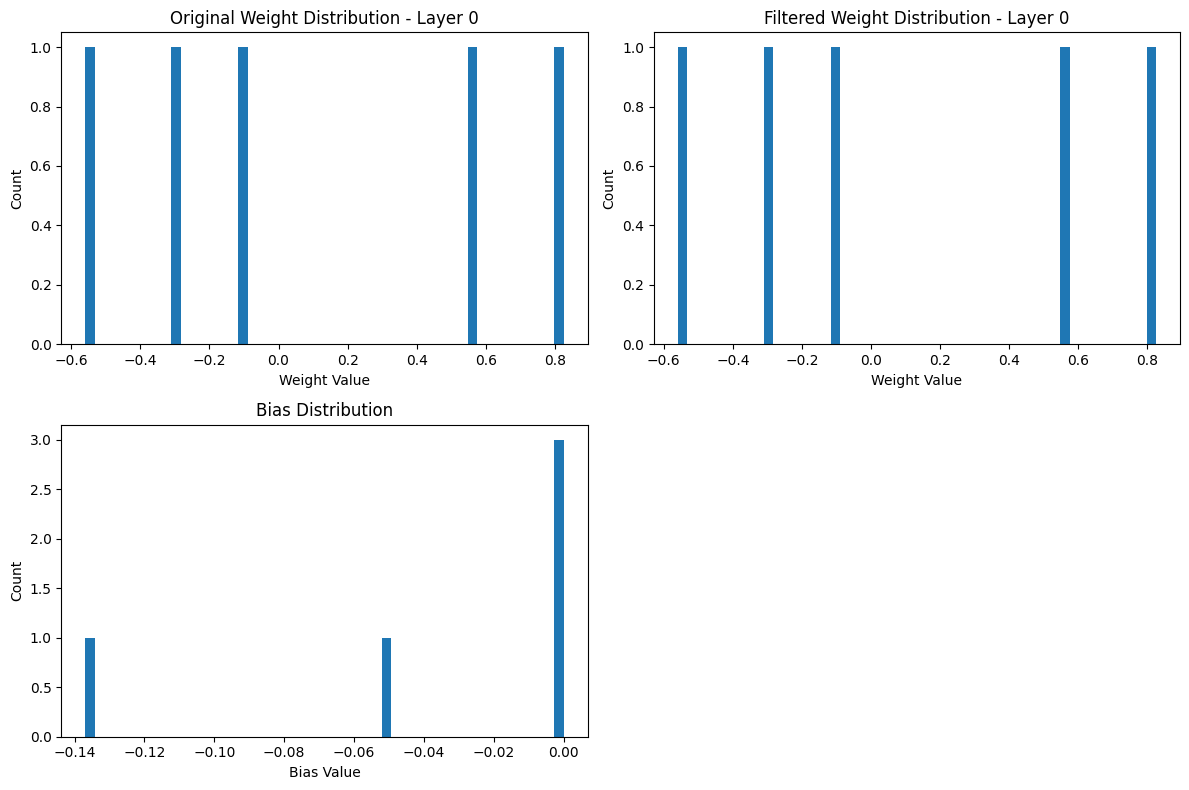


Analyzing Layer 2: dense_25

Weight Statistics:
mean: -0.0029
std: 0.1097
min: -0.7062
max: 0.3945
sparsity: 0.0000
total_weights: 8,400
nonzero_weights: 8,400
bias_mean: -0.0043
bias_std: 0.0205
bias_nonzero: 120


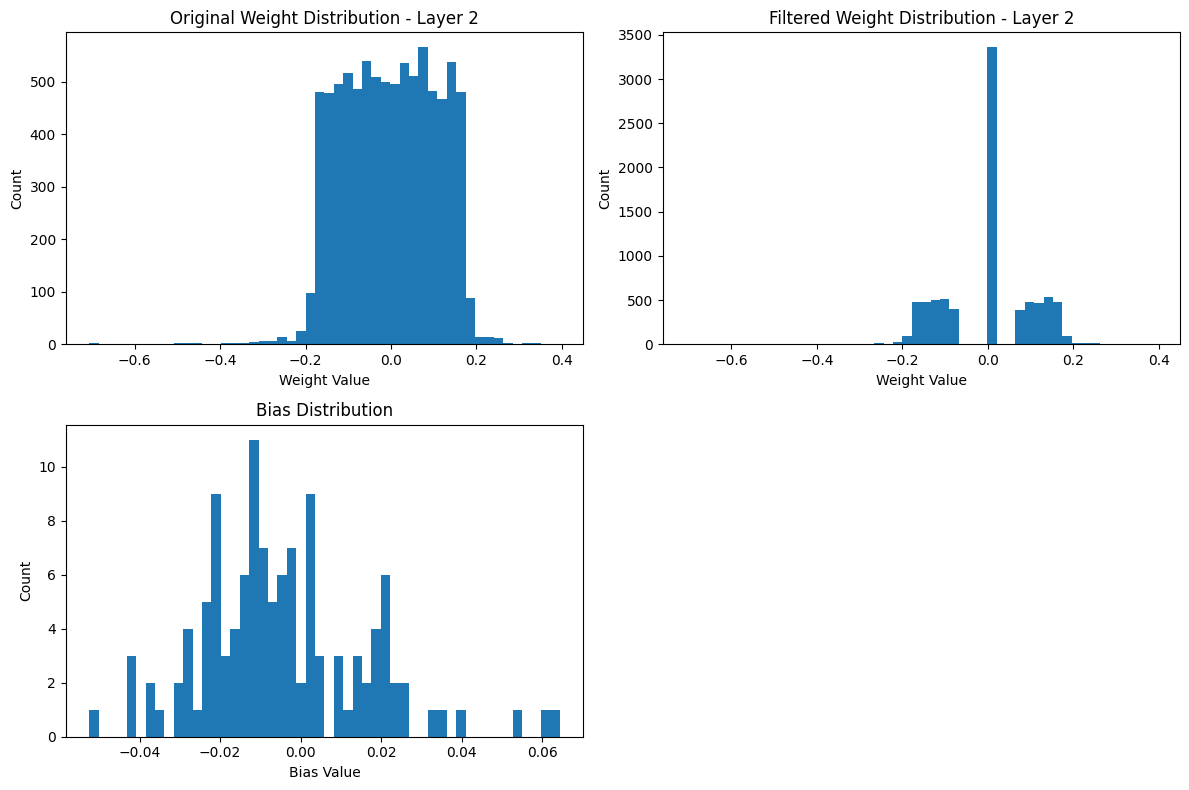


Analyzing Layer 3: dense_26

Weight Statistics:
mean: -0.0203
std: 0.1999
min: -0.6429
max: 0.8603
sparsity: 0.0000
total_weights: 120
nonzero_weights: 120
bias_mean: 0.0363
bias_std: 0.0000
bias_nonzero: 1


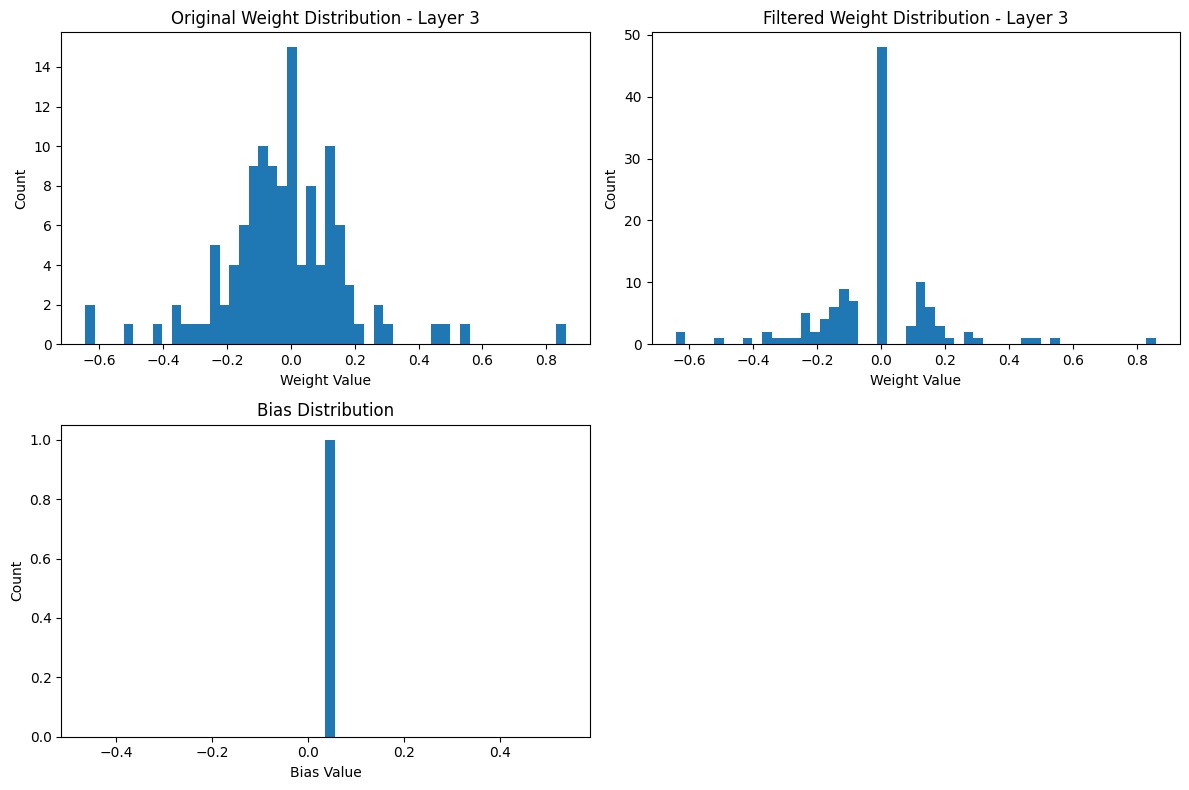


Filtered Model Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)


Analyzing Filtered Model:
Layer Information:

Layer 0: conv1d_7 (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten_11 (Flatten)

Layer 2: dense_25 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_26 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d_7

Weight Statistics:
mean: 0.0889
std: 0.5259
min: -0.5598
max: 0.8252
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0375
bias_std: 0.0534
bias_nonzero: 2
Skipping layer 0: conv1d_7 (Conv1D)


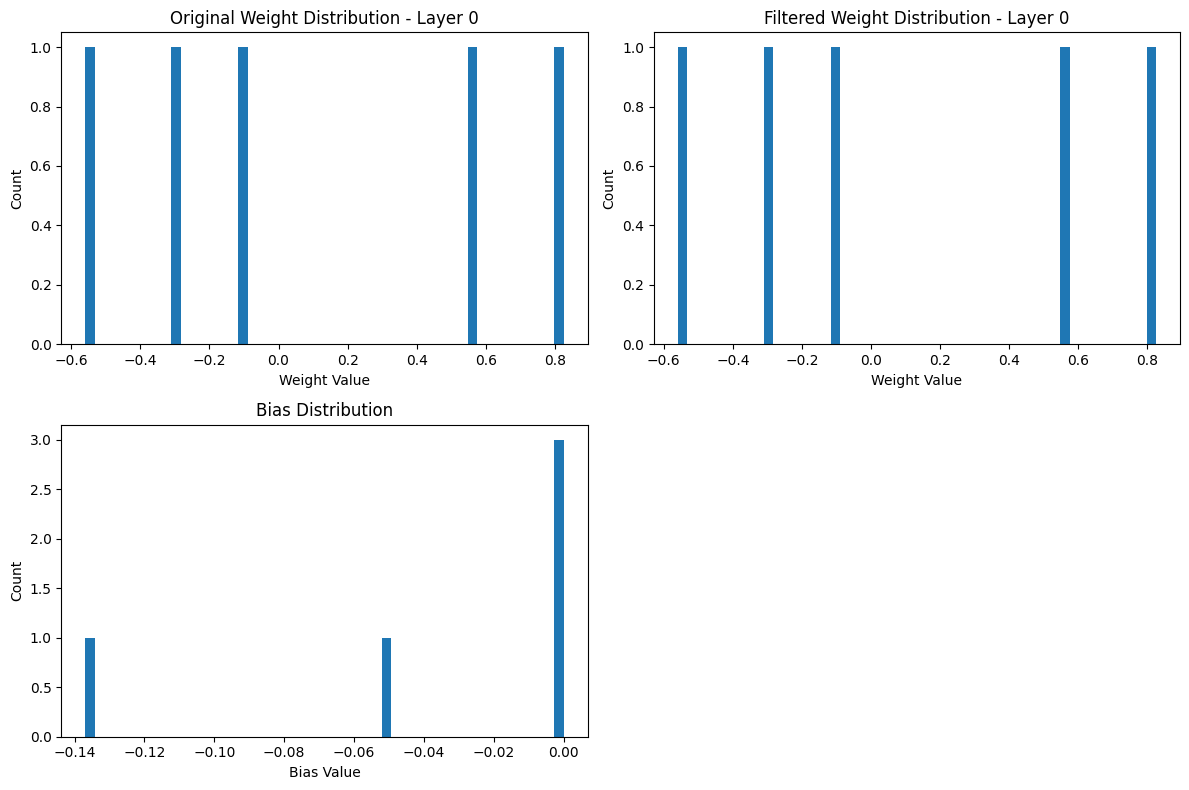


Analyzing Layer 2: dense_25

Weight Statistics:
mean: -0.0029
std: 0.1065
min: -0.7062
max: 0.3945
sparsity: 0.4000
total_weights: 8,400
nonzero_weights: 5,040
bias_mean: -0.0043
bias_std: 0.0205
bias_nonzero: 120


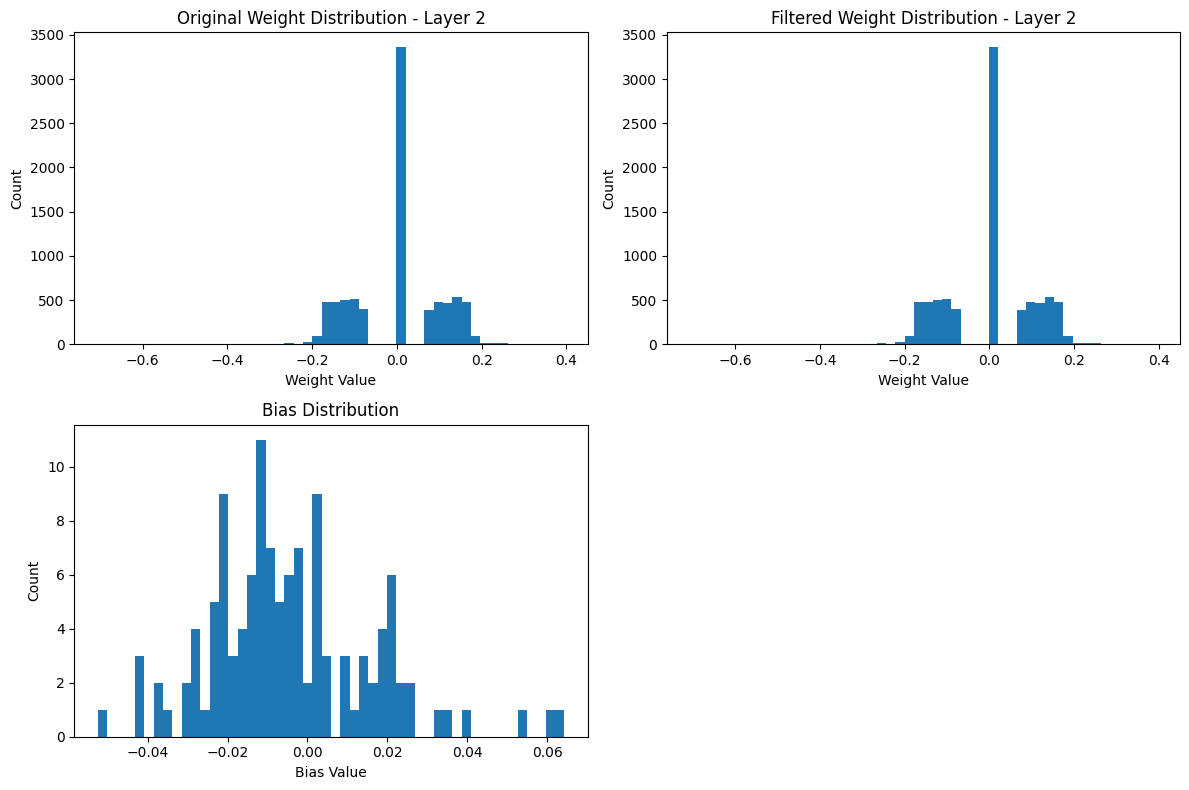


Analyzing Layer 3: dense_26

Weight Statistics:
mean: -0.0191
std: 0.1981
min: -0.6429
max: 0.8603
sparsity: 0.4000
total_weights: 120
nonzero_weights: 72
bias_mean: 0.0363
bias_std: 0.0000
bias_nonzero: 1


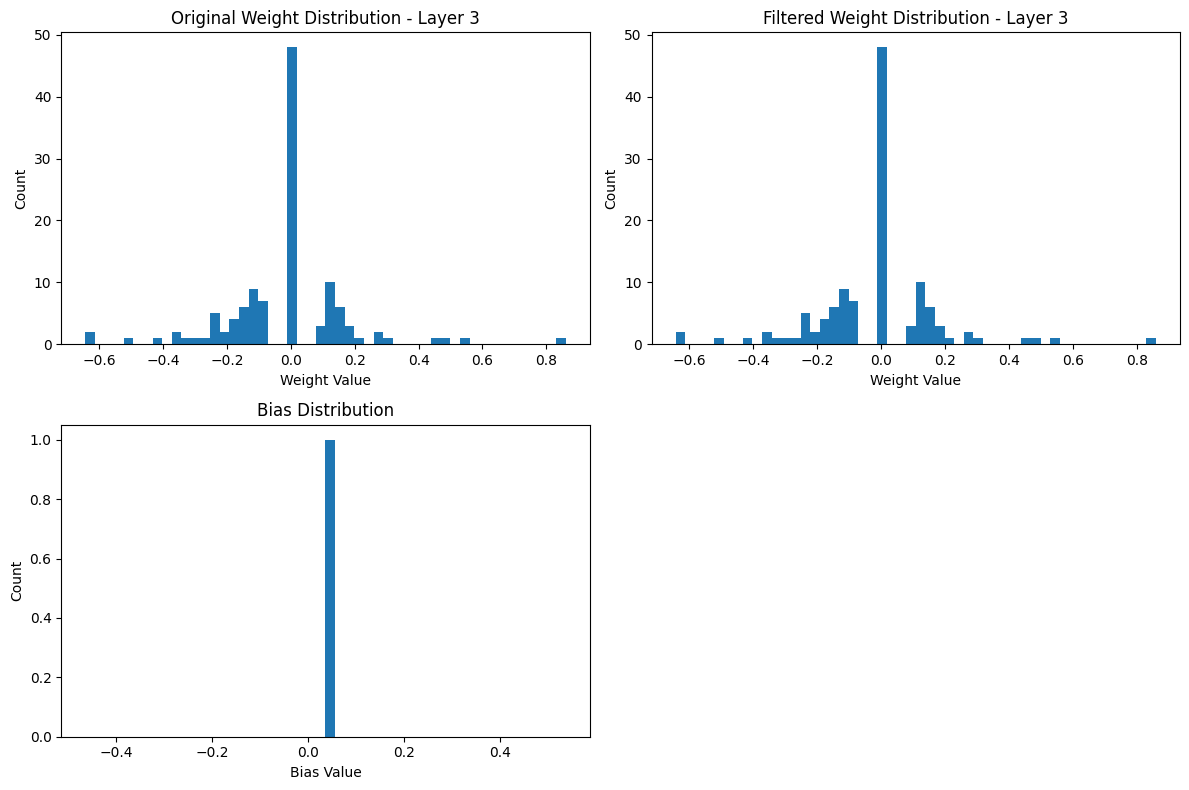

[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


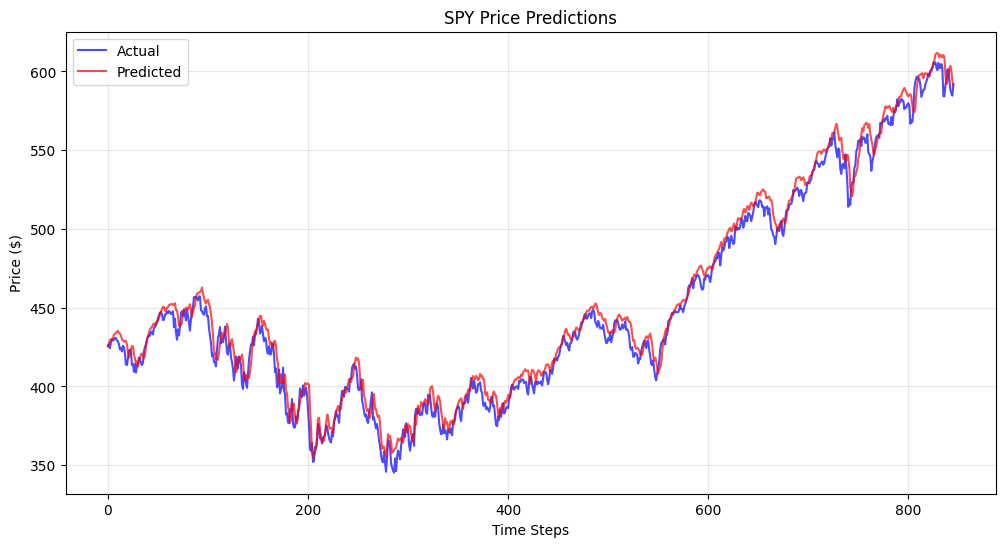


Prediction Statistics:
Mean Squared Error: 63.98
Mean Absolute Error: 6.31


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


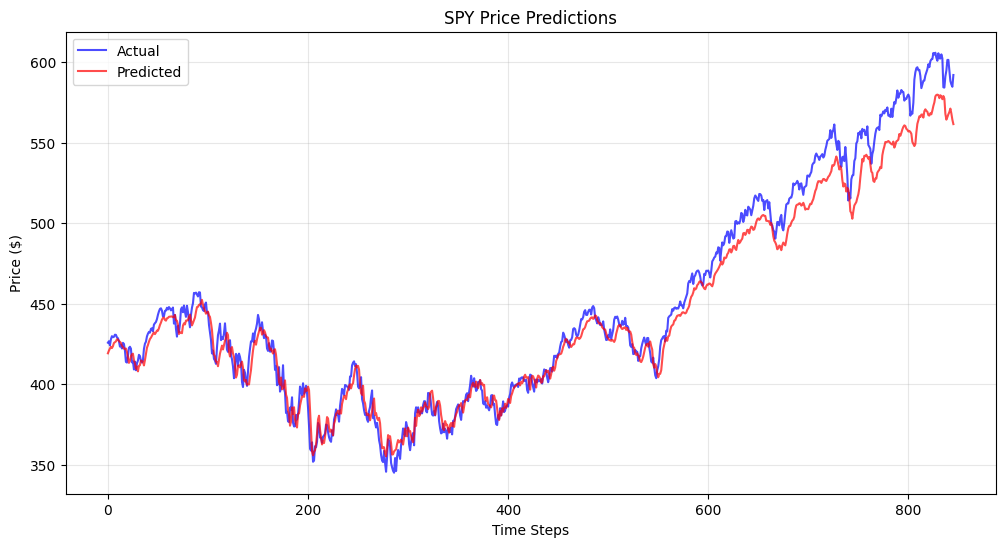


Prediction Statistics:
Mean Squared Error: 146.70
Mean Absolute Error: 9.16


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import tensorflow as tf

class SimpleLayerAnalyzer:
    def __init__(self, model):
        """Initialize analyzer with a trained model"""
        self.model = model
        self.filtered_weights = {}
        self.non_prunable_layers = {
            "Conv2D", "Flatten", "BatchNormalization", "LayerNormalization",
            "MaxPooling2D", "AveragePooling2D", "Dropout", "Conv1D"
        }

    def print_layer_info(self):
        """Print basic information about each layer"""
        for i, layer in enumerate(self.model.layers):
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            weights = layer.get_weights()
            if weights:
                print(f"Number of weight arrays: {len(weights)}")
                for j, w in enumerate(weights):
                    print(f"Weight array {j} shape: {w.shape}")

    def analyze_weights(self, layer_index: int) -> Dict[str, np.ndarray]:
        """Analyze weights of a specific layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()

        if not weights:
            return {}

        analysis = {}

        # Analyze the main weights (usually the first array)
        if len(weights) > 0:
            main_weights = weights[0]
            analysis['mean'] = np.mean(main_weights)
            analysis['std'] = np.std(main_weights)
            analysis['min'] = np.min(main_weights)
            analysis['max'] = np.max(main_weights)
            analysis['sparsity'] = np.mean(main_weights == 0)
            analysis['total_weights'] = main_weights.size
            analysis['nonzero_weights'] = np.count_nonzero(main_weights)

        # Analyze bias if present (usually the second array)
        if len(weights) > 1:
            bias = weights[1]
            analysis['bias_mean'] = np.mean(bias)
            analysis['bias_std'] = np.std(bias)
            analysis['bias_nonzero'] = np.count_nonzero(bias)

        return analysis

    def filter_weights(self, layer_index: int, stats: Dict[str, float]) -> List[np.ndarray]:
        """Filter weights while preserving original tensor shapes."""
        layer = self.model.layers[layer_index]
        layer_type = layer.__class__.__name__
        weights = layer.get_weights()

        # Skip layers that should not be altered
        if not weights or layer_type in self.non_prunable_layers:
            print(f"Skipping layer {layer_index}: {layer.name} ({layer_type})")
            return weights  # Return original weights for non-prunable layers

        filtered = []
        main_weights = weights[0]

        # Calculate percentiles on the absolute values of weights
        abs_weights = np.abs(main_weights)
        threshold = np.percentile(abs_weights, 40)  # Keep top 50% of weights by magnitude

        # Create mask and apply it while preserving original shape
        mask = abs_weights > threshold
        filtered_weights = main_weights * mask  # Zero out small weights
        filtered.append(filtered_weights)  # Keep original shape

        # Keep bias if present, unchanged
        if len(weights) > 1:
            filtered.append(weights[1])

        return filtered

    def plot_weight_distribution(self, layer_index: int):
        """Plot the distribution of weights in a layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        filtered = self.filtered_weights.get(layer_index, None)

        if not weights:
            print(f"Layer {layer_index} ({layer.name}) has no weights to plot")
            return

        plt.figure(figsize=(12, 8))

        # Plot original weights
        plt.subplot(2, 2, 1)
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f'Original Weight Distribution - Layer {layer_index}')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')

        # Plot filtered weights if available
        if filtered is not None:
            plt.subplot(2, 2, 2)
            plt.hist(filtered[0].flatten(), bins=50)
            plt.title(f'Filtered Weight Distribution - Layer {layer_index}')
            plt.xlabel('Weight Value')
            plt.ylabel('Count')

        # Plot bias if present
        if len(weights) > 1:
            plt.subplot(2, 2, 3)
            plt.hist(weights[1].flatten(), bins=50)
            plt.title('Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

def create_filtered_model(original_model, filtered_weights):
    """Create a new model with the same architecture and assign filtered weights"""
    new_model = tf.keras.models.clone_model(original_model)

    if original_model.optimizer:
        new_model.compile(
            optimizer=original_model.optimizer.__class__(),
            loss=original_model.loss,
            metrics=original_model.metrics
        )

    # Set weights for all layers
    for i, layer in enumerate(original_model.layers):
        if i in filtered_weights:
            new_model.layers[i].set_weights(filtered_weights[i])
        else:
            # Copy original weights for layers that weren't filtered
            new_model.layers[i].set_weights(layer.get_weights())

    return new_model

def analyze_model(model):
    """Helper function to run all analyses and create filtered model"""
    analyzer = SimpleLayerAnalyzer(model)
    filtered_weights = {}

    print("Layer Information:")
    analyzer.print_layer_info()

    for i, layer in enumerate(model.layers):
        if layer.get_weights():
            print(f"\nAnalyzing Layer {i}: {layer.name}")

            stats = analyzer.analyze_weights(i)
            print("\nWeight Statistics:")
            for key, value in stats.items():
                if isinstance(value, (int, np.integer)):
                    print(f"{key}: {value:,}")
                else:
                    print(f"{key}: {value:.4f}")

            filtered = analyzer.filter_weights(i, stats)
            if filtered:
                filtered_weights[i] = filtered
                analyzer.filtered_weights[i] = filtered

            analyzer.plot_weight_distribution(i)

    return filtered_weights
def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Main execution
if __name__ == "__main__":
    print("\nStarting layer analysis...")
    SPYModel1.summary()

    print("\nAnalyzing Original Model:")
    filtered_weights = analyze_model(SPYModel1)

    filtered_model = create_filtered_model(SPYModel1, filtered_weights)
    print("\nFiltered Model Summary:")
    filtered_model.summary()
    filtered_model.save("pruned.keras")
    print("\nAnalyzing Filtered Model:")
    analyze_model(filtered_model)

    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/pruned.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/pruned.keras"

    pruned = load_model(file_path)

    pruned.summary()

In [ ]:

# Load the original model
file_path = "/content/spy_predictor_model.keras"
SPYModel1 = load_model(file_path)

# Print summary of SPYModel1
print("Summary of SPYModel1:")
SPYModel1.summary()

# Print weights of the 2nd layer in SPYModel1
print("\nWeights of layer 2 in SPYModel1:")
print(SPYModel1.layers[2].get_weights())

# Load the pruned model
file_path = "/content/pruned.keras"
pruned = load_model(file_path)

# Print summary of pruned model
print("\nSummary of pruned model:")
pruned.summary()

# Print weights of the 2nd layer in pruned model
print("\nWeights of layer 2 in pruned model:")
print(pruned.layers[2].get_weights())


Summary of SPYModel1:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Weights of layer 2 in SPYModel1:
[array([[ 0.14052707,  0.0457619 , -0.10370222, ...,  0.06998175,
        -0.136457  , -0.00715829],
       [ 0.04958834, -0.05725298, -0.10516082, ..., -0.0159013 ,
         0.0703409 , -0.09581519],
       [-0.09523559, -0.00663307, -0.19160628, ...,  0.03795511,
         0.08492676,  0.07655796],
       ...,
       [-0.06080041,  0.03148605,  0.14148068, ...,  0.01594193,
        -0.03109293,  0.11553323],
       [-0.00902513, -0.08101536,  0.15662323, ...,  0.0195076 ,
        -0.18247388,  0.13115093],
       [-0.06987676,  0.04514104,  0.03155771, ...,  0.02549106,
        -0.04925977, -0.12842357]], dtype=float32), array([-0.00304291, -0.00433281, -0.02341293, -0.03011704, -0.02181483,
       -0.01631362, -0.02223346, -0.04165333, -0.00172747, -0.00824633,
       -0.00377819, -0.01410966, -0.0104022 ,  0.02005209,  0.00519603,
       -0.01092027,  0.00015092, -0.02204994, -0.01383452,  0.02042571,
       -0.01079861, -0.0108013 ,  0.00174764, -0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Weights of layer 2 in pruned model:
[array([[ 0.14052707,  0.        , -0.10370222, ...,  0.        ,
        -0.136457  , -0.        ],
       [ 0.        , -0.        , -0.10516082, ..., -0.        ,
         0.        , -0.09581519],
       [-0.09523559, -0.        , -0.19160628, ...,  0.        ,
         0.08492676,  0.07655796],
       ...,
       [-0.        ,  0.        ,  0.14148068, ...,  0.        ,
        -0.        ,  0.11553323],
       [-0.        , -0.08101536,  0.15662323, ...,  0.        ,
        -0.18247388,  0.13115093],
       [-0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.        , -0.12842357]], dtype=float32), array([-0.00304291, -0.00433281, -0.02341293, -0.03011704, -0.02181483,
       -0.01631362, -0.02223346, -0.04165333, -0.00172747, -0.00824633,
       -0.00377819, -0.01410966, -0.0104022 ,  0.02005209,  0.00519603,
       -0.01092027,  0.00015092, -0.02204994, -0.01383452,  0.02042571,
       -0.01079861, -0.0108013 ,  0.00174764,

Kept Non-Zero Weights and Biases:
Layer 1:
Weights shape: (5,), Biases shape: (5,)
Layer 2:
Weights shape: (5460,), Biases shape: (120,)
Layer 3:
Weights shape: (78,), Biases shape: (1,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Layer
from typing import List, Tuple, Dict, Union

def get_layer_output_shape(layer: Layer, prev_shape: tuple) -> tuple:
    """Calculate output shape of a layer given previous layer's output shape."""
    if isinstance(layer, Conv1D):
        return (prev_shape[0], layer.filters)
    elif isinstance(layer, Flatten):
        return (np.prod(prev_shape),)
    elif isinstance(layer, Dense):
        return (layer.units,)
    else:
        return prev_shape

def create_compact_model(original_path: str, pruned_path: str) -> Tuple[tf.keras.Model, List[Dict]]:
    """
    Create compact model preserving Conv1D and Flatten layers while pruning Dense layers.

    Args:
        original_path: Path to original model
        pruned_path: Path to pruned model
    Returns:
        Tuple of (compact_model, layer_info)
    """
    # Load models
    original_model = load_model(original_path)
    pruned_model = load_model(pruned_path)

    # Initialize model
    model = Sequential()
    layer_info = []
    current_shape = original_model.input_shape[1:]

    # First, create the model structure without setting weights
    for layer in pruned_model.layers:
        if isinstance(layer, Conv1D):
            model.add(Conv1D(
                filters=layer.filters,
                kernel_size=layer.kernel_size,
                padding=layer.padding,
                activation=layer.activation,
                input_shape=current_shape if len(model.layers) == 0 else None
            ))
            current_shape = get_layer_output_shape(layer, current_shape)
            layer_info.append({
                'type': 'Conv1D',
                'weights': layer.get_weights()
            })

        elif isinstance(layer, Flatten):
            model.add(Flatten())
            current_shape = get_layer_output_shape(layer, current_shape)
            layer_info.append({
                'type': 'Flatten',
                'weights': []
            })

        elif isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            # Find active neurons
            active_outputs = np.where(np.any(weights != 0, axis=0))[0]
            if len(active_outputs) == 0:
                active_outputs = np.array([0])  # Keep at least one neuron

            # Create pruned weights and biases
            pruned_weights = weights[:, active_outputs]
            pruned_biases = biases[active_outputs]

            # Add Dense layer
            model.add(Dense(
                units=len(active_outputs),
                activation=layer.activation,
                input_shape=(np.prod(current_shape),) if len(model.layers) == 0 else None
            ))
            current_shape = (len(active_outputs),)
            layer_info.append({
                'type': 'Dense',
                'weights': [pruned_weights, pruned_biases],
                'active_outputs': active_outputs
            })

    # Build the model with a sample input to initialize weights
    sample_input = np.zeros((1,) + original_model.input_shape[1:])
    model.predict(sample_input)

    # Now set the weights for all layers
    for layer_idx, info in enumerate(layer_info):
        if info['weights']:  # Only set weights if they exist
            model.layers[layer_idx].set_weights(info['weights'])

    return model, layer_info

def verify_model(original_model: tf.keras.Model, compact_model: tf.keras.Model, layer_info: List[Dict]) -> None:
    """
    Verify the compact model produces similar outputs to the original model.
    """
    # Generate sample input
    input_shape = original_model.input_shape[1:]
    sample_input = np.random.random((1,) + input_shape)

    # Get outputs
    original_output = original_model.predict(sample_input)
    compact_output = compact_model.predict(sample_input)

    # Get the final layer info
    final_layer = layer_info[-1]
    if final_layer['type'] == 'Dense':
        active_outputs = final_layer['active_outputs']
        comparable_original_output = original_output[:, active_outputs]
    else:
        comparable_original_output = original_output

    print("\nModel Verification:")
    print(f"Original model input shape: {sample_input.shape}")
    print(f"Original model output shape: {original_output.shape}")
    print(f"Compact model input shape: {sample_input.shape}")
    print(f"Compact model output shape: {compact_output.shape}")

    if comparable_original_output.shape == compact_output.shape:
        max_diff = np.max(np.abs(comparable_original_output - compact_output))
        print(f"\nMaximum difference between outputs: {max_diff:.6f}")
    else:
        print("\nWarning: Output shapes differ, cannot compare directly")

# Example usage
if __name__ == "__main__":
    original_path = "/content/spy_predictor_model.keras"
    pruned_path = "/content/pruned.keras"

    # Create compact model
    compact_model, layer_info = create_compact_model(original_path, pruned_path)

    # Print model summary
    print("\nCompact model summary:")
    compact_model.summary()

    # Print layer information
    print("\nLayer details:")
    for i, info in enumerate(layer_info):
        print(f"\nLayer {i} ({info['type']}):")
        if info['type'] == 'Dense':
            print(f"Active neurons: {len(info['active_outputs'])}")
            print(f"Weight shape: {info['weights'][0].shape}")
        elif info['type'] == 'Conv1D':
            print(f"Filters: {info['weights'][0].shape[-1]}")
            print(f"Kernel size: {info['weights'][0].shape[0]}")

    # Save the compact model
    compact_model.save("compact_model.keras")

    # Verify the model
    original_model = load_model(original_path)
    verify_model(original_model, compact_model, layer_info)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Compact model summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)


Layer details:

Layer 0 (Conv1D):
Filters: 5
Kernel size: 1

Layer 1 (Flatten):

Layer 2 (Dense):
Active neurons: 120
Weight shape: (70, 120)

Layer 3 (Dense):
Active neurons: 1
Weight shape: (120, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Model Verification:
Original model input shape: (1, 14, 1)
Original model output shape: (1, 1)
Compact model input shape: (1, 14, 1)
Compact model output shape: (1, 1)

Maximum difference between outputs: 0.103061


In [ ]:
compact_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


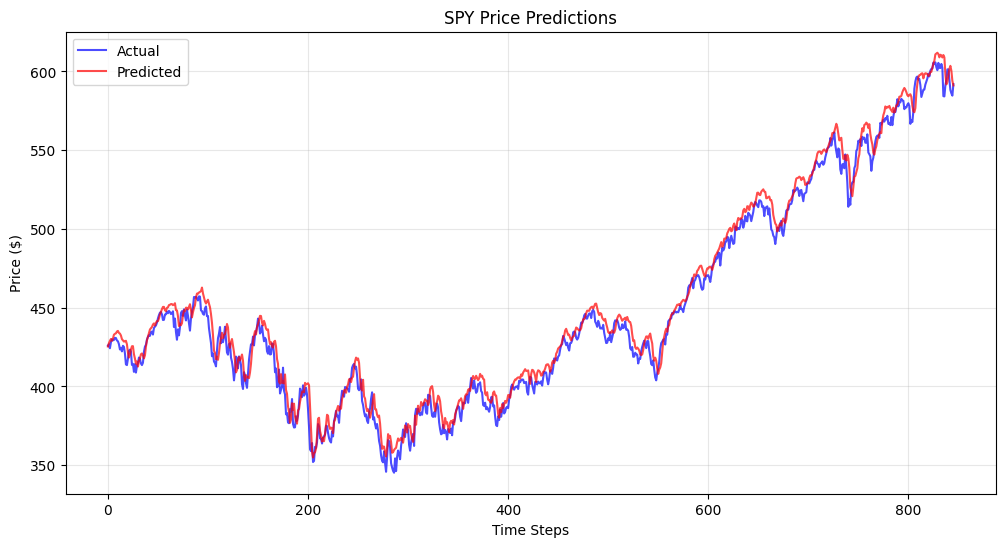


Prediction Statistics:
Mean Squared Error: 63.98
Mean Absolute Error: 6.31


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


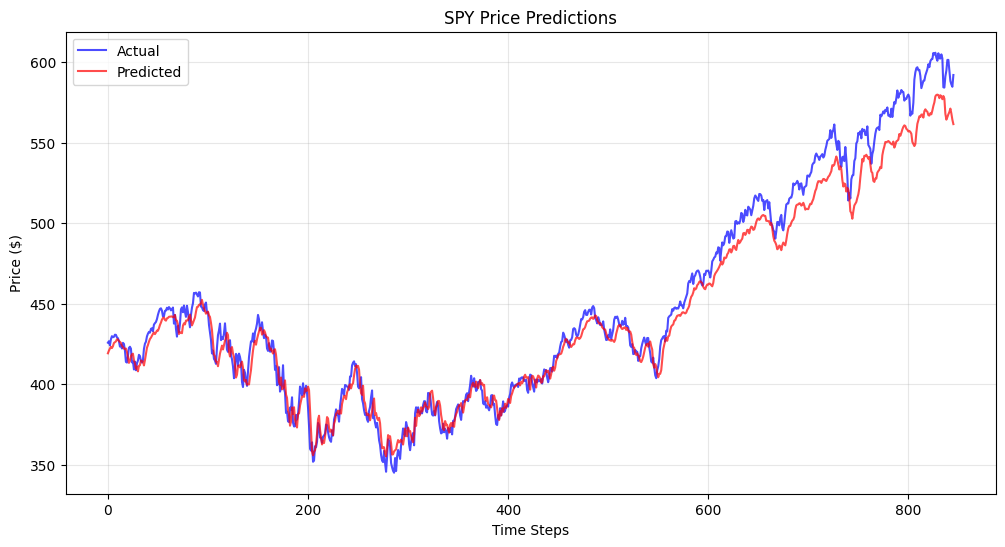


Prediction Statistics:
Mean Squared Error: 146.70
Mean Absolute Error: 9.16


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/compact_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/compact_model.keras"

    pruned = load_model(file_path)

    pruned.summary()

[*********************100%***********************]  1 of 1 completed


Model Comparison Report: SPYModel vs CompactModel

1. Architecture Comparison:

2. Parameter Comparison:
              Total Parameters  Trainable Parameters  Non-trainable Parameters
SPYModel                8651.0                8651.0                       0.0
CompactModel            8651.0                8651.0                       0.0

3. Weight Distribution:


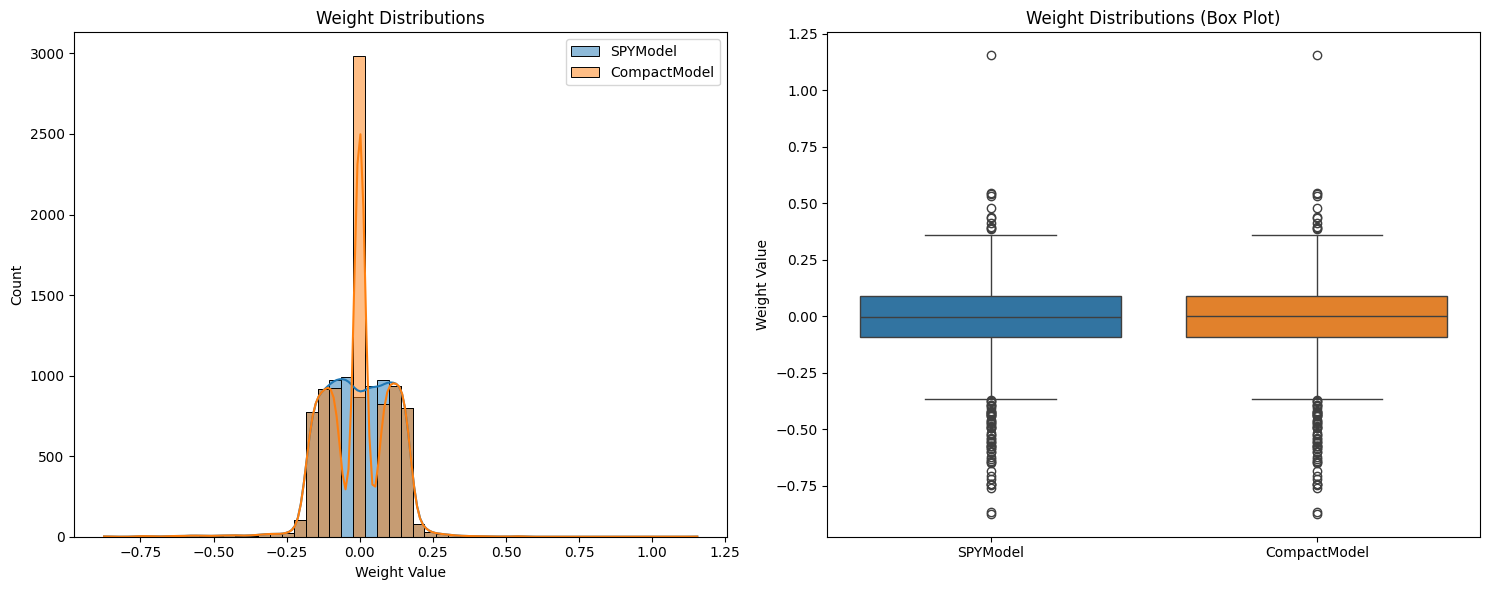


4. Performance Metrics:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


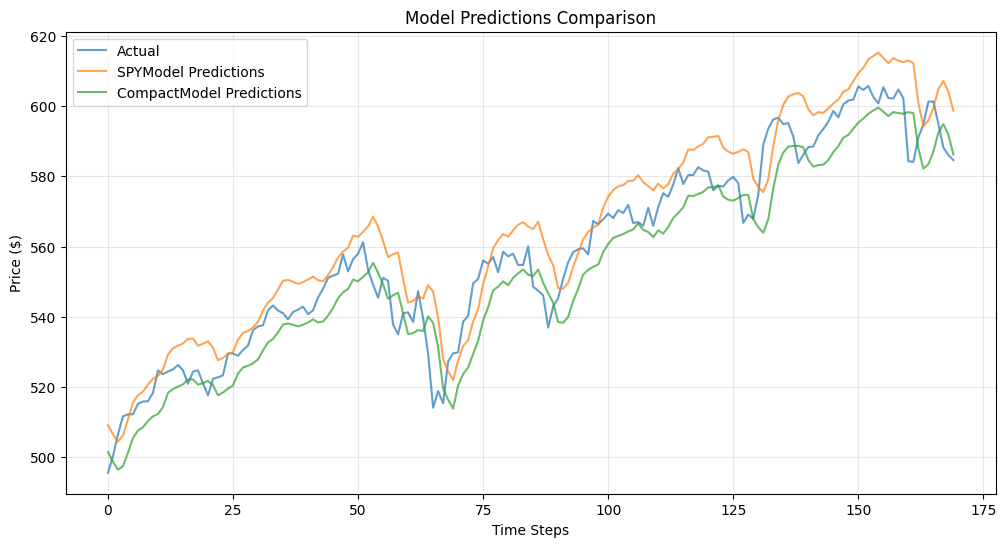

                     MSE       RMSE       MAE        R2
SPYModel      101.446256  10.072053  8.084161  0.865630
CompactModel   79.957995   8.941923  7.573118  0.894093


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class ModelComparator:
    def __init__(self, model1_path, model2_path, model1_name="Model 1", model2_name="Model 2"):
        """
        Initialize ModelComparator with paths to two Keras models.

        Args:
            model1_path (str): Path to first model
            model2_path (str): Path to second model
            model1_name (str): Name for first model
            model2_name (str): Name for second model
        """
        self.model1 = load_model(model1_path)
        self.model2 = load_model(model2_path)
        self.model1_name = model1_name
        self.model2_name = model2_name

    def compare_architectures(self):
        """Compare layer architectures of both models."""
        comparison = []

        # Get maximum number of layers between both models
        max_layers = max(len(self.model1.layers), len(self.model2.layers))

        for i in range(max_layers):
            layer1 = self.model1.layers[i] if i < len(self.model1.layers) else None
            layer2 = self.model2.layers[i] if i < len(self.model2.layers) else None

            layer_info = {
                'Layer Index': i,
                f'{self.model1_name} Layer': layer1.__class__.__name__ if layer1 else 'N/A',
                f'{self.model1_name} Output Shape': str(layer1.output_shape) if layer1 else 'N/A',
                f'{self.model2_name} Layer': layer2.__class__.__name__ if layer2 else 'N/A',
                f'{self.model2_name} Output Shape': str(layer2.output_shape) if layer2 else 'N/A'
            }
            comparison.append(layer_info)

        return pd.DataFrame(comparison)

    def compare_parameters(self):
        """Compare parameter counts between models."""
        def get_param_details(model):
            trainable_params = sum([layer.count_params() for layer in model.layers])
            non_trainable_params = sum([np.sum([K.count_params(p) for p in layer.non_trainable_weights])
                                     for layer in model.layers])
            return {
                'Total Parameters': trainable_params + non_trainable_params,
                'Trainable Parameters': trainable_params,
                'Non-trainable Parameters': non_trainable_params
            }

        model1_params = get_param_details(self.model1)
        model2_params = get_param_details(self.model2)

        comparison = pd.DataFrame({
            self.model1_name: model1_params,
            self.model2_name: model2_params
        }).T

        return comparison

    def compare_weights_distribution(self):
        """Compare weight distributions between models."""
        plt.figure(figsize=(15, 6))

        # Collect all weights
        weights1 = np.concatenate([layer.get_weights()[0].flatten()
                                 for layer in self.model1.layers
                                 if len(layer.get_weights()) > 0])
        weights2 = np.concatenate([layer.get_weights()[0].flatten()
                                 for layer in self.model2.layers
                                 if len(layer.get_weights()) > 0])

        # Plot distributions
        plt.subplot(1, 2, 1)
        sns.histplot(weights1, bins=50, kde=True, label=self.model1_name)
        sns.histplot(weights2, bins=50, kde=True, label=self.model2_name)
        plt.title('Weight Distributions')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')
        plt.legend()

        # Plot box plots
        plt.subplot(1, 2, 2)
        data = {
            self.model1_name: weights1,
            self.model2_name: weights2
        }
        sns.boxplot(data=data)
        plt.title('Weight Distributions (Box Plot)')
        plt.ylabel('Weight Value')

        plt.tight_layout()
        plt.show()

    def compare_predictions(self, X_test, y_test, scaler):
        """
        Compare model predictions and performance metrics.

        Args:
            X_test: Test input data
            y_test: True test values
            scaler: Fitted scaler object for inverse transformation
        """
        # Get predictions
        pred1 = self.model1.predict(X_test)
        pred2 = self.model2.predict(X_test)

        # Inverse transform if scaler provided
        if scaler:
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
            pred1 = scaler.inverse_transform(pred1)
            pred2 = scaler.inverse_transform(pred2)

        # Calculate metrics
        metrics = {
            self.model1_name: {
                'MSE': mean_squared_error(y_test, pred1),
                'RMSE': np.sqrt(mean_squared_error(y_test, pred1)),
                'MAE': mean_absolute_error(y_test, pred1),
                'R2': r2_score(y_test, pred1)
            },
            self.model2_name: {
                'MSE': mean_squared_error(y_test, pred2),
                'RMSE': np.sqrt(mean_squared_error(y_test, pred2)),
                'MAE': mean_absolute_error(y_test, pred2),
                'R2': r2_score(y_test, pred2)
            }
        }

        # Plot predictions
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='Actual', alpha=0.7)
        plt.plot(pred1, label=f'{self.model1_name} Predictions', alpha=0.7)
        plt.plot(pred2, label=f'{self.model2_name} Predictions', alpha=0.7)
        plt.title('Model Predictions Comparison')
        plt.xlabel('Time Steps')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return pd.DataFrame(metrics).T

    def generate_report(self, X_test=None, y_test=None, scaler=None):
        """Generate comprehensive comparison report."""
        print(f"Model Comparison Report: {self.model1_name} vs {self.model2_name}")
        print("\n1. Architecture Comparison:")
        #print(self.compare_architectures().to_string())

        print("\n2. Parameter Comparison:")
        print(self.compare_parameters().to_string())

        print("\n3. Weight Distribution:")
        self.compare_weights_distribution()

        if X_test is not None and y_test is not None:
            print("\n4. Performance Metrics:")
            print(self.compare_predictions(X_test, y_test, scaler).to_string())
# Fetch and process data
data = fetch_data()
X, y, scaler = process_data(data)

# Split data into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize comparator with your model paths
comparator = ModelComparator(
    '/content/spy_predictor_model.keras',
    '/content/compact_model.keras',
    model1_name="SPYModel",
    model2_name="CompactModel"
)

# Generate comprehensive comparison report
comparator.generate_report(X_test, y_test, scaler)

In [ ]:
pip install psutil

In [ ]:
def prepare_plot_data(results):
    """
    Prepare plot data in a format suitable for CSV export.

    Args:
        results (pd.DataFrame): Benchmark results DataFrame

    Returns:
        dict: Dictionary of DataFrames for each metric
    """
    plot_data = {}

    # Prepare data for each metric
    metrics = {
        'execution_time': 'Execution Time (seconds)',
        'peak_memory_mb': 'Peak Memory (MB)',
        'mse': 'Mean Squared Error',
        'mae': 'Mean Absolute Error'
    }

    for metric, metric_name in metrics.items():
        # Create DataFrame with data_size as index and models as columns
        df = pd.pivot_table(
            results,
            values=metric,
            index='data_size',
            columns='model',
            aggfunc='first'
        )
        df.index.name = 'Data Size (days)'
        df.columns.name = metric_name
        plot_data[metric] = df

    return plot_data

def export_plot_data(plot_data, base_filename='benchmark_results'):
    """
    Export plot data to CSV files.

    Args:
        plot_data (dict): Dictionary of DataFrames for each metric
        base_filename (str): Base filename for CSV files
    """
    metric_names = {
        'execution_time': 'execution_time',
        'peak_memory_mb': 'peak_memory',
        'mse': 'mean_squared_error',
        'mae': 'mean_absolute_error'
    }

    for metric, name in metric_names.items():
        filename = f"{base_filename}_{name}.csv"
        plot_data[metric].to_csv(filename)
        print(f"Saved {name} data to {filename}")

def plot_benchmark_results(results):
    """
    Plot benchmark results and return plot data.

    Args:
        results (pd.DataFrame): Benchmark results DataFrame

    Returns:
        dict: Dictionary containing the plot data
    """
    if len(results) == 0:
        print("No results to plot!")
        return {}

    # Prepare plot data
    plot_data = prepare_plot_data(results)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot execution time
    plot_data['execution_time'].plot(ax=ax1, marker='o')
    ax1.set_title('Execution Time vs Data Size')
    ax1.set_xlabel('Data Size (days)')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True)

    # Plot peak memory usage
    plot_data['peak_memory_mb'].plot(ax=ax2, marker='o')
    ax2.set_title('Peak Memory Usage vs Data Size')
    ax2.set_xlabel('Data Size (days)')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)

    # Plot MSE
    plot_data['mse'].plot(ax=ax3, marker='o')
    ax3.set_title('Mean Squared Error vs Data Size')
    ax3.set_xlabel('Data Size (days)')
    ax3.set_ylabel('MSE')
    ax3.grid(True)

    # Plot MAE
    plot_data['mae'].plot(ax=ax4, marker='o')
    ax4.set_title('Mean Absolute Error vs Data Size')
    ax4.set_xlabel('Data Size (days)')
    ax4.set_ylabel('MAE')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    return plot_data

def run_benchmark_comparison(model_paths, data_sizes=[ 1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,  5000, 5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000], export_csv=True):
    """
    Run complete benchmark comparison for multiple models.

    Args:
        model_paths (list): List of paths to saved Keras models
        data_sizes (list): List of lookback days to test
        export_csv (bool): Whether to export plot data to CSV files

    Returns:
        tuple: (results DataFrame, plot data dictionary)
    """
    print("Starting benchmark comparison...")
    print(f"Testing models: {model_paths}")
    print(f"Data sizes: {data_sizes} days")

    # Run benchmarks
    results = benchmark_models(model_paths, data_sizes)

    if len(results) > 0:
        # Display results
        print("\nBenchmark Results:")
        print(results.to_string())

        # Plot results and get plot data
        plot_data = plot_benchmark_results(results)

        # Export plot data if requested
        if export_csv:
            export_plot_data(plot_data)

        # Print summary statistics
        print("\nMemory Usage Summary:")
        for model in results['model'].unique():
            model_data = results[results['model'] == model]
            print(f"\nModel: {model}")
            print(f"Peak Memory: {model_data['peak_memory_mb'].max():.2f} MB")
            print(f"Average Memory: {model_data['peak_memory_mb'].mean():.2f} MB")

        return results, plot_data
    else:
        print("No results were generated. Please check your model paths and data sizes.")
        return pd.DataFrame(), {}

# Example of how the plot data is structured
def print_plot_data_example(plot_data):
    """Print example of plot data structure"""
    print("\nPlot Data Structure Example:")
    for metric, df in plot_data.items():
        print(f"\n{metric} data:")
        print(df)

Starting benchmark comparison...
Testing models: ['/content/compact_model.keras', '/content/spy_predictor_model.keras']
Data sizes: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000] days

Testing dataset size: 1000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.32 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 1500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.61 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 2000 days


Memory after data fetch: 0.71 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -26.36 MB

Testing dataset size: 2500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.80 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.45 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.39 MB

Testing dataset size: 3000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.04 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.03 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 3500 days


Memory after data fetch: 1.08 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.46 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 4000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.02 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 4500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.04 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -5.54 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 5000 days


Memory after data fetch: 1.03 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.61 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 5500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.65 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.04 MB

Testing dataset size: 6000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.46 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.49 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 6500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.99 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 7000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.04 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -5.20 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 7500 days


Memory after data fetch: 2.11 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.35 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 8000 days


Memory after data fetch: 1.00 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 8500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.96 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 9000 days


Memory after data fetch: 1.00 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.15 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 9500 days


Memory after data fetch: 1.06 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -6.70 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 10000 days


Memory after data fetch: 1.29 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.52 MB
Memory after model load: 0.52 MB
Memory after predictions: 0.77 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.27 MB

Testing dataset size: 10500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.04 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.04 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 11000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.44 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.44 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 11500 days


Memory after data fetch: 1.32 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 12000 days


Memory after data fetch: 0.99 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -7.62 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 12500 days


Memory after data fetch: 1.66 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.52 MB
Memory after predictions: 1.17 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 13000 days


Memory after data fetch: 0.83 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing dataset size: 13500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.00 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 14000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.95 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 14500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.01 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -6.48 MB

Testing dataset size: 15000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.16 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.09 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.09 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 15500 days


Memory after data fetch: 0.97 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.18 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 16000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.03 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 16500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.01 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing dataset size: 17000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.81 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: -6.62 MB
Memory after predictions: -5.06 MB

Testing dataset size: 17500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.21 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.25 MB
Memory after model load: 0.51 MB
Memory after predictions: 0.80 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 18000 days


Memory after data fetch: 1.04 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 18500 days


Memory after data fetch: 0.80 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 19000 days


Memory after data fetch: 1.00 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 19500 days


Memory after data fetch: 0.96 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 1.29 MB
Memory after model load: 1.80 MB
Memory after predictions: 3.23 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 20000 days


Memory after data fetch: 2.37 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.13 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Benchmark Results:
                                 model  data_size  execution_time  peak_memory_mb  final_memory_mb  baseline_memory_mb       mse      mae  samples_processed
0         /content/compact_model.keras       1000            1.07         1000.18          1000.18             1000.18   49.6425   5.6195                671
1   /content/spy_predictor_model.keras       1000            1.39         1000.18          1000.18             1000.18   65.1115   6.3370                671
2         /content/compact_model.keras       1500            1.15         1000.79          1000.78          

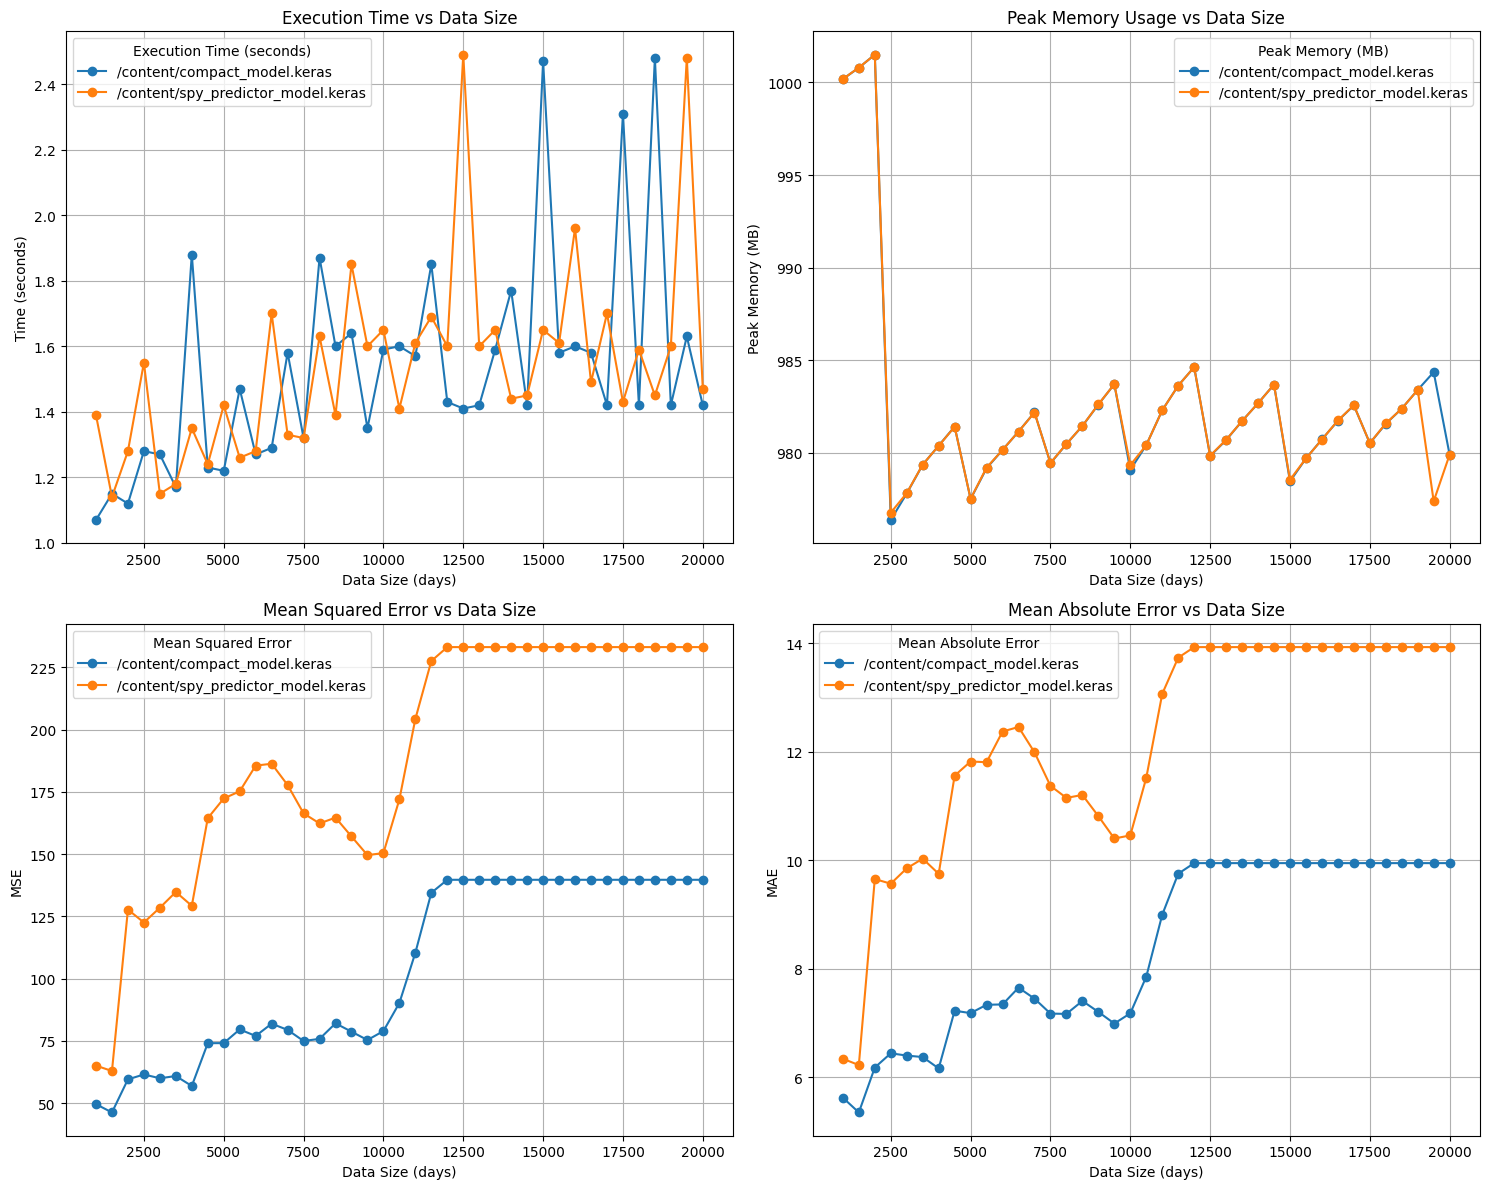

Saved execution_time data to benchmark_results_execution_time.csv
Saved peak_memory data to benchmark_results_peak_memory.csv
Saved mean_squared_error data to benchmark_results_mean_squared_error.csv
Saved mean_absolute_error data to benchmark_results_mean_absolute_error.csv

Memory Usage Summary:

Model: /content/compact_model.keras
Peak Memory: 1001.50 MB
Average Memory: 982.56 MB

Model: /content/spy_predictor_model.keras
Peak Memory: 1001.49 MB
Average Memory: 982.40 MB


In [ ]:
# List of model paths to compare
model_paths = ['/content/compact_model.keras', '/content/spy_predictor_model.keras']

# Run benchmark
results = run_benchmark_comparison(model_paths)


Starting layer analysis...

Analyzing Original Model:
Layer Information:

Layer 0: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten (Flatten)

Layer 2: dense (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_1 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d

Weight Statistics:
mean: 0.0251
std: 0.4216
min: -0.7210
max: 0.4801
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0208
bias_std: 0.0177
bias_nonzero: 3

Weight Count Statistics:
Original weights: 5 total, 5 non-zero (100.00%)
After filtering: 5 total, 4 non-zero (80.00%)
Removed 1 weights (20.00% of non-zero weights)


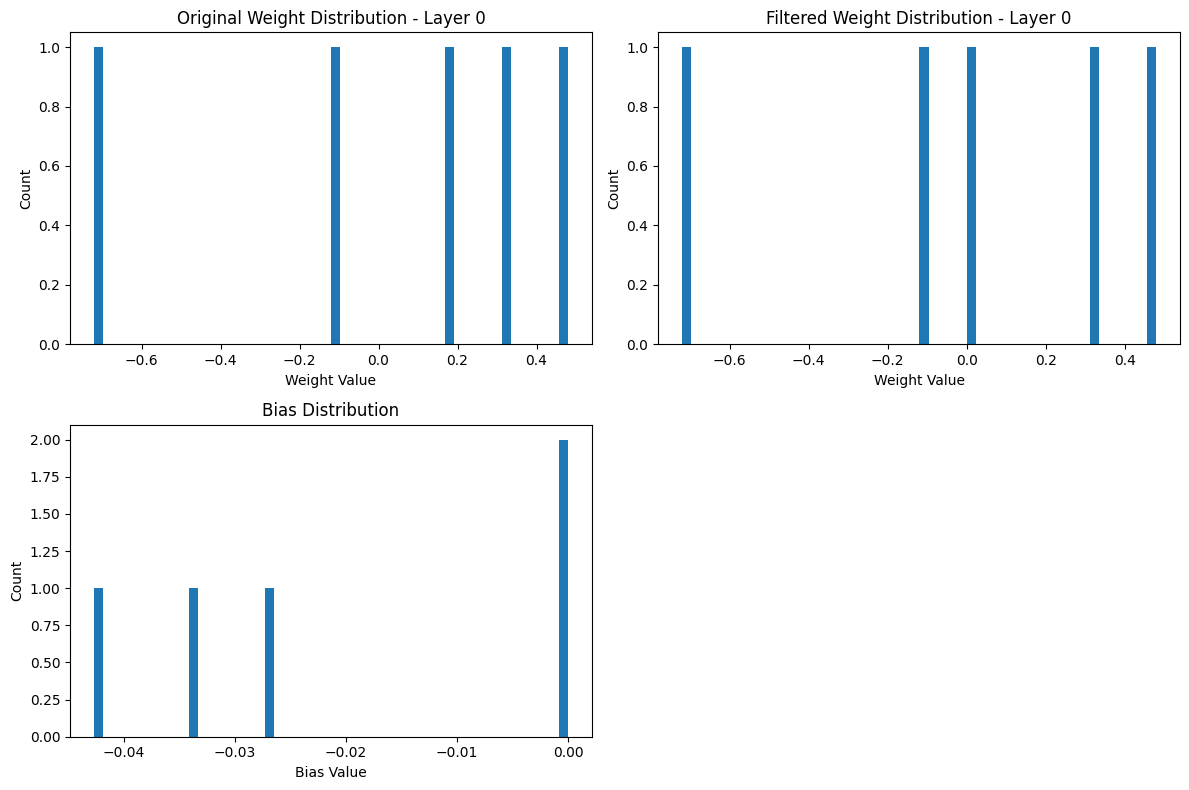


Analyzing Layer 2: dense

Weight Statistics:
mean: -0.0046
std: 0.1173
min: -0.8745
max: 0.5444
sparsity: 0.0000
total_weights: 8,400
nonzero_weights: 8,400
bias_mean: -0.0011
bias_std: 0.0184
bias_nonzero: 119

Weight Count Statistics:
Original weights: 8,400 total, 8,400 non-zero (100.00%)
After filtering: 8,400 total, 6,720 non-zero (80.00%)
Removed 1,680 weights (20.00% of non-zero weights)


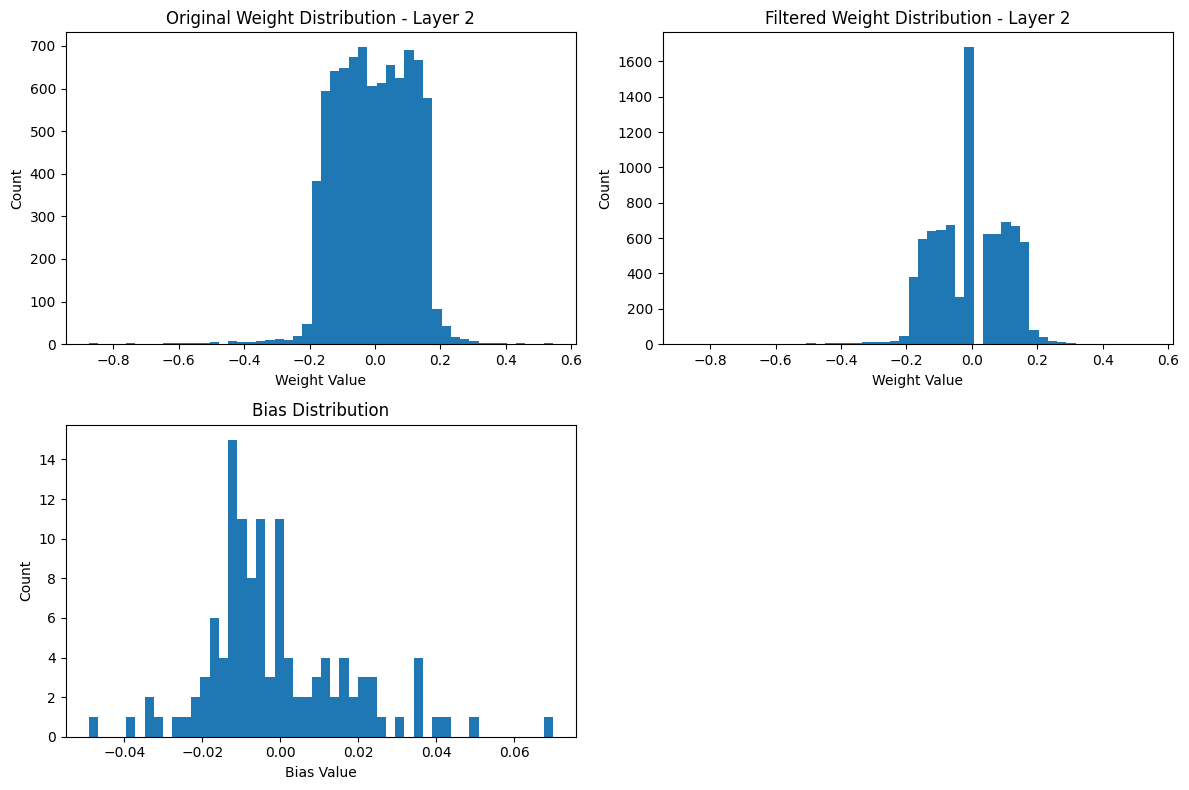


Analyzing Layer 3: dense_1

Weight Statistics:
mean: -0.0363
std: 0.2014
min: -0.7613
max: 1.1543
sparsity: 0.0000
total_weights: 120
nonzero_weights: 120
bias_mean: 0.0367
bias_std: 0.0000
bias_nonzero: 1

Weight Count Statistics:
Original weights: 120 total, 120 non-zero (100.00%)
After filtering: 120 total, 96 non-zero (80.00%)
Removed 24 weights (20.00% of non-zero weights)


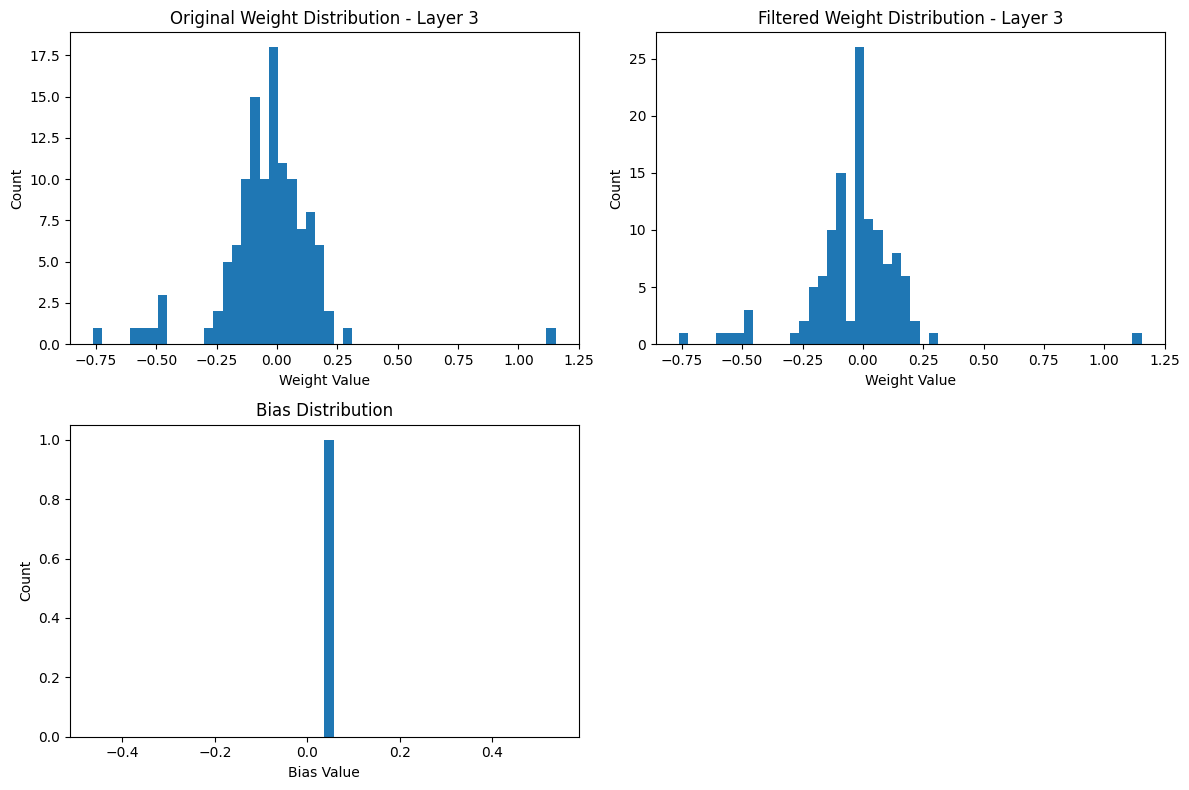

ValueError: Shape mismatch: Expected input of 14, got 70

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import tensorflow as tf


class SimpleLayerAnalyzer:
    def __init__(self, model):
        self.model = model
        self.filtered_weights = {}

    def print_layer_info(self):
        for i, layer in enumerate(self.model.layers):
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            weights = layer.get_weights()
            if weights:
                print(f"Number of weight arrays: {len(weights)}")
                for j, w in enumerate(weights):
                    print(f"Weight array {j} shape: {w.shape}")

    def analyze_weights(self, layer_index: int) -> Dict[str, np.ndarray]:
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        if not weights:
            return {}
        analysis = {}
        if len(weights) > 0:
            main_weights = weights[0]
            analysis['mean'] = np.mean(main_weights)
            analysis['std'] = np.std(main_weights)
            analysis['min'] = np.min(main_weights)
            analysis['max'] = np.max(main_weights)
            analysis['sparsity'] = np.mean(main_weights == 0)
            analysis['total_weights'] = main_weights.size
            analysis['nonzero_weights'] = np.count_nonzero(main_weights)
        if len(weights) > 1:
            bias = weights[1]
            analysis['bias_mean'] = np.mean(bias)
            analysis['bias_std'] = np.std(bias)
            analysis['bias_nonzero'] = np.count_nonzero(bias)
        return analysis

    def filter_weights(self, layer_index: int, stats: Dict[str, float]) -> List[np.ndarray]:
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        if not weights:
            return []
        filtered = []
        main_weights = weights[0]
        lower_percentile = np.percentile(main_weights, 40)
        upper_percentile = np.percentile(main_weights, 60)
        bottom_mask = (main_weights <= lower_percentile)
        top_mask = (main_weights > upper_percentile)
        combined_mask = bottom_mask | top_mask
        original_nonzero = np.count_nonzero(main_weights)
        original_total = main_weights.size
        filtered_weights = np.where(combined_mask, main_weights, 0)
        filtered_nonzero = np.count_nonzero(filtered_weights)
        print("\nWeight Count Statistics:")
        print(f"Original weights: {original_total:,} total, {original_nonzero:,} non-zero ({original_nonzero/original_total*100:.2f}%)")
        print(f"After filtering: {original_total:,} total, {filtered_nonzero:,} non-zero ({filtered_nonzero/original_total*100:.2f}%)")
        print(f"Removed {original_nonzero - filtered_nonzero:,} weights ({(original_nonzero - filtered_nonzero)/original_nonzero*100:.2f}% of non-zero weights)")
        filtered.append(filtered_weights)
        if len(weights) > 1:
            filtered.append(weights[1])
        return filtered

    def plot_weight_distribution(self, layer_index: int):
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        filtered = self.filtered_weights.get(layer_index, None)
        if not weights:
            print(f"Layer {layer_index} ({layer.name}) has no weights to plot")
            return
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f'Original Weight Distribution - Layer {layer_index}')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')
        if filtered is not None:
            plt.subplot(2, 2, 2)
            plt.hist(filtered[0].flatten(), bins=50)
            plt.title(f'Filtered Weight Distribution - Layer {layer_index}')
            plt.xlabel('Weight Value')
            plt.ylabel('Count')
        if len(weights) > 1:
            plt.subplot(2, 2, 3)
            plt.hist(weights[1].flatten(), bins=50)
            plt.title('Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()


def create_revised_model(original_model, filtered_weights: Dict[int, List[np.ndarray]]) -> tf.keras.Model:
    input_shape = original_model.input_shape[1:]
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    prev_shape = None

    for layer_idx, layer in enumerate(original_model.layers):
        if isinstance(layer, tf.keras.layers.Flatten):
            x = tf.keras.layers.Flatten()(x)
            prev_shape = np.prod(input_shape)
            continue

        if layer_idx in filtered_weights:
            weights = filtered_weights[layer_idx]
            if not weights:
                continue

            main_weights = weights[0]
            if prev_shape is None:
                prev_shape = main_weights.shape[0]

            nonzero_mask = np.any(main_weights != 0, axis=0)
            units = np.sum(nonzero_mask)

            if isinstance(layer, tf.keras.layers.Dense):
                new_weights = main_weights[~np.all(main_weights == 0, axis=1)][:, nonzero_mask]
                new_bias = weights[1][nonzero_mask] if len(weights) > 1 else None

                if new_weights.shape[0] != prev_shape:
                    raise ValueError(f"Shape mismatch: Expected input of {prev_shape}, got {new_weights.shape[0]}")

                new_layer = tf.keras.layers.Dense(
                    units=units,
                    activation=layer.activation,
                    use_bias=layer.use_bias
                )
                new_layer.build((None, new_weights.shape[0]))

                if new_bias is not None:
                    new_layer.set_weights([new_weights, new_bias])
                else:
                    new_layer.set_weights([new_weights])

                x = new_layer(x)
                prev_shape = units
        else:
            config = layer.get_config()
            new_layer = layer.__class__.from_config(config)
            x = new_layer(x)

    revised_model = tf.keras.Model(inputs=inputs, outputs=x)
    if hasattr(original_model, 'optimizer') and original_model.optimizer:
        revised_model.compile(
            optimizer=original_model.optimizer.__class__(),
            loss=original_model.loss,
            metrics=original_model.metrics
        )
    return revised_model


def analyze_model_revision(original_model, revised_model):
    print("\nModel Comparison:")
    total_params_original = original_model.count_params()
    total_params_revised = revised_model.count_params()

    for i, (orig_layer, rev_layer) in enumerate(zip(original_model.layers, revised_model.layers)):
        orig_weights = orig_layer.get_weights()
        rev_weights = rev_layer.get_weights()
        if orig_weights and rev_weights:
            orig_units = orig_weights[0].shape[-1]
            rev_units = rev_weights[0].shape[-1]
            reduction = (1 - rev_units / orig_units) * 100
            print(f"\nLayer {i}:")
            print(f"Original units: {orig_units:,}")
            print(f"Revised units: {rev_units:,}")
            print(f"Reduction: {reduction:.1f}%")

    total_reduction = (1 - total_params_revised / total_params_original) * 100
    print(f"\nTotal parameters reduction: {total_reduction:.1f}%")
    return revised_model


def analyze_model(model):
    analyzer = SimpleLayerAnalyzer(model)
    filtered_weights = {}
    print("Layer Information:")
    analyzer.print_layer_info()

    for i, layer in enumerate(model.layers):
        if layer.get_weights():
            print(f"\nAnalyzing Layer {i}: {layer.name}")
            stats = analyzer.analyze_weights(i)
            print("\nWeight Statistics:")
            for key, value in stats.items():
                if isinstance(value, (int, np.integer)):
                    print(f"{key}: {value:,}")
                else:
                    print(f"{key}: {value:.4f}")
            filtered = analyzer.filter_weights(i, stats)
            if filtered:
                filtered_weights[i] = filtered
                analyzer.filtered_weights[i] = filtered
            analyzer.plot_weight_distribution(i)
    return filtered_weights


if __name__ == "__main__":
    # Load your model here
    # model = tf.keras.models.load_model("your_model.keras")

    print("\nStarting layer analysis...")
    # model.summary()

    print("\nAnalyzing Original Model:")
    filtered_weights = analyze_model(SPYModel1)

    revised_model = create_revised_model(SPYModel1, filtered_weights)
    print("\nRevised Model Summary:")
    revised_model.summary()

    analyze_model_revision(SPYModel1, revised_model)
    revised_model.save("revised_model.keras")

    print("\nAnalyzing Revised Model:")
    analyze_model(revised_model)


[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


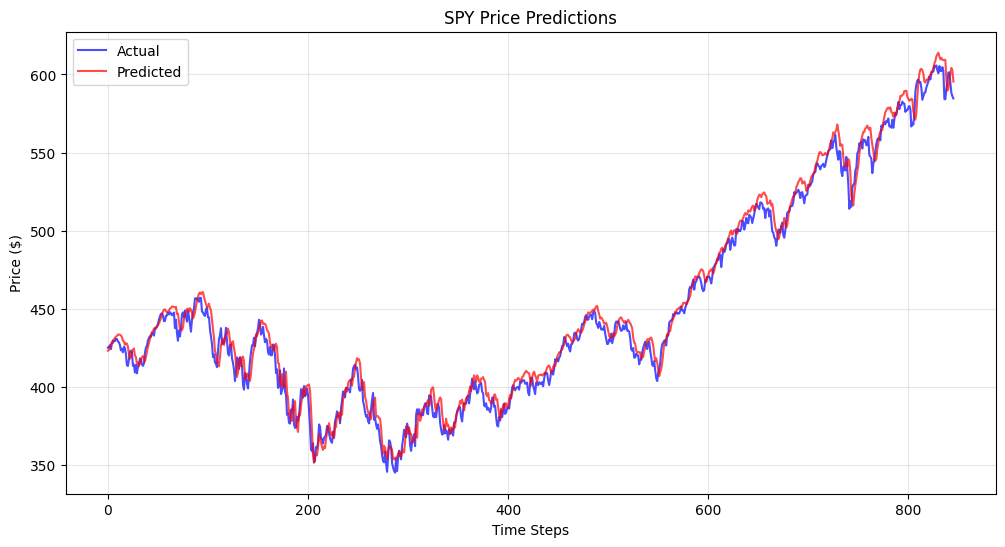


Prediction Statistics:
Mean Squared Error: 57.16
Mean Absolute Error: 5.90


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


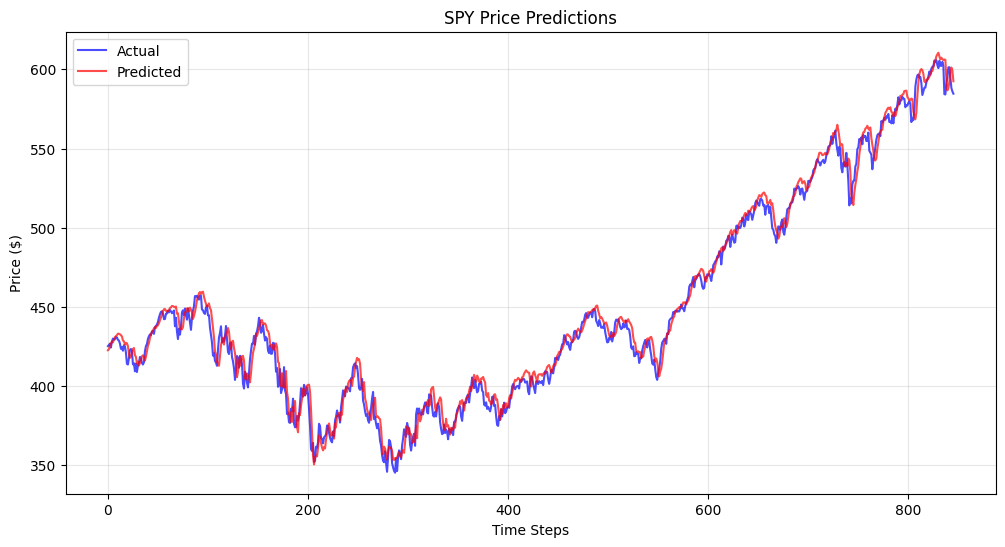


Prediction Statistics:
Mean Squared Error: 48.61
Mean Absolute Error: 5.35


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

In [ ]:
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/pruned.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/pruned2.keras"

    pruned = load_model(file_path)

    pruned.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Conv1D
from typing import Dict, List, Tuple, Optional

class ModelPruner:
    def __init__(self, model: Model):
        """Initialize pruner with original model"""
        self.original_model = model
        self.pruned_weights: Dict[int, Tuple[np.ndarray, Optional[np.ndarray]]] = {}
        self.layer_configs: Dict[int, dict] = {}
        self.input_shapes: Dict[int, tuple] = {}

    def get_active_indices(self, weights: np.ndarray, prev_active_indices: Optional[np.ndarray] = None) -> np.ndarray:
        """
        Get indices of non-zero rows in weight matrix, safely handling dimensionality
        """
        try:
            # Ensure weights is 2D
            if len(weights.shape) == 1:
                weights = weights.reshape(-1, 1)
            elif len(weights.shape) > 2:
                weights = weights.reshape(weights.shape[0], -1)

            # Handle previous active indices if provided
            if prev_active_indices is not None and len(prev_active_indices) > 0:
                # Check if indices are valid
                if np.max(prev_active_indices) < weights.shape[1]:
                    weights = weights[:, prev_active_indices]
                else:
                    # If indices are invalid, use all columns
                    prev_active_indices = None

            # Find rows with any non-zero weights
            active_rows = np.any(weights != 0, axis=1)
            active_indices = np.where(active_rows)[0]

            # Ensure we don't return empty array
            if len(active_indices) == 0:
                # Keep at least one neuron if all are zero
                active_indices = np.array([0])

            return active_indices

        except Exception as e:
            print(f"Warning: Error in get_active_indices: {e}")
            # Return index 0 as fallback
            return np.array([0])

    def get_layer_input_shape(self, layer) -> tuple:
        """Safely get input shape for any layer type"""
        try:
            # Try multiple methods to get input shape
            if hasattr(layer, '_build_input_shape'):
                shape = layer._build_input_shape
            elif hasattr(layer, 'input_spec') and layer.input_spec is not None:
                if hasattr(layer.input_spec[0], 'shape'):
                    shape = layer.input_spec[0].shape
            else:
                shape = layer.input_shape

            # Ensure we have a valid shape
            if shape is None or not any(isinstance(dim, (int, type(None))) for dim in shape):
                # Use a default shape if none found
                return (None, 1)
            return shape

        except:
            # Return default shape if all methods fail
            return (None, 1)

    def analyze_layer(self, layer_idx: int) -> Tuple[bool, Optional[dict]]:
        """Analyze if layer can be pruned and return its configuration"""
        layer = self.original_model.layers[layer_idx]

        # Store input shape for each layer
        input_shape = self.get_layer_input_shape(layer)
        self.input_shapes[layer_idx] = input_shape

        # Only process Dense layers
        if not isinstance(layer, Dense):
            return False, None

        config = {
            'units': layer.units,
            'activation': layer.activation,
            'use_bias': layer.use_bias,
            'kernel_initializer': layer.kernel_initializer,
            'bias_initializer': layer.bias_initializer,
            'kernel_regularizer': layer.kernel_regularizer,
            'bias_regularizer': layer.bias_regularizer,
            'activity_regularizer': layer.activity_regularizer,
            'kernel_constraint': layer.kernel_constraint,
            'bias_constraint': layer.bias_constraint
        }

        return True, config

    def extract_pruned_weights(self) -> None:
        """Extract non-zero weights and corresponding biases from pruned model"""
        prev_active_indices = None

        for i, layer in enumerate(self.original_model.layers):
            try:
                can_prune, config = self.analyze_layer(i)

                if can_prune:
                    weights = layer.get_weights()
                    if not weights:
                        continue

                    weight_matrix = weights[0]
                    bias = weights[1] if len(weights) > 1 and layer.use_bias else None

                    # Get indices of active neurons
                    active_indices = self.get_active_indices(weight_matrix, prev_active_indices)

                    # Extract active weights safely
                    try:
                        if prev_active_indices is not None and len(prev_active_indices) > 0:
                            pruned_weights = weight_matrix[active_indices][:, prev_active_indices]
                        else:
                            pruned_weights = weight_matrix[active_indices]
                    except:
                        # Fallback: just use the active rows
                        pruned_weights = weight_matrix[active_indices]

                    # Extract active biases if they exist
                    pruned_bias = bias[active_indices] if bias is not None else None

                    self.pruned_weights[i] = (pruned_weights, pruned_bias)
                    self.layer_configs[i] = config

                    # Update the configuration with new number of units
                    self.layer_configs[i]['units'] = len(active_indices)

                    # Update active indices for next layer
                    prev_active_indices = active_indices
                else:
                    # Reset active indices for non-Dense layers
                    prev_active_indices = None

            except Exception as e:
                print(f"Warning: Error processing layer {i}: {e}")
                prev_active_indices = None
                continue

    def build_pruned_model(self) -> Model:
        """Build new model with pruned architecture"""
        try:
            # Get input shape from first layer
            first_layer = self.original_model.layers[0]
            input_shape = self.get_layer_input_shape(first_layer)
            if input_shape is None or len(input_shape) < 2:
                input_shape = (None, 1)  # Default fallback shape

            # Create input layer
            inputs = Input(shape=input_shape[1:])
            x = inputs

            # Track the current shape as we build
            current_shape = input_shape

            # Rebuild model architecture
            for i, layer in enumerate(self.original_model.layers):
                try:
                    if i in self.layer_configs:
                        # Create new Dense layer with pruned weights
                        config = self.layer_configs[i].copy()

                        # Get proper input dimension
                        if isinstance(current_shape, tuple):
                            input_dim = current_shape[-1]
                        else:
                            input_dim = current_shape

                        if input_dim is None or input_dim < 1:
                            input_dim = 1

                        dense = Dense(config['units'], input_dim=input_dim,
                                    **{k: v for k, v in config.items() if k != 'units'})
                        x = dense(x)

                        # Set pruned weights
                        if i in self.pruned_weights:
                            weights, bias = self.pruned_weights[i]
                            if bias is not None:
                                dense.set_weights([weights, bias])
                            else:
                                dense.set_weights([weights])

                        # Update current shape
                        current_shape = (None, config['units'])

                    else:
                        # Copy non-Dense layer
                        layer_config = layer.get_config()
                        new_layer = layer.__class__.from_config(layer_config)
                        x = new_layer(x)

                        # Update current shape from the new layer
                        if hasattr(new_layer, 'compute_output_shape'):
                            current_shape = new_layer.compute_output_shape(current_shape)

                except Exception as e:
                    print(f"Warning: Error building layer {i}: {e}")
                    continue

            # Create and compile new model
            pruned_model = Model(inputs=inputs, outputs=x)

            # Copy compilation settings if original model was compiled
            if hasattr(self.original_model, 'optimizer') and self.original_model.optimizer:
                pruned_model.compile(
                    optimizer=self.original_model.optimizer.__class__(),
                    loss=self.original_model.loss,
                    metrics=self.original_model.metrics
                )

            return pruned_model

        except Exception as e:
            print(f"Error building pruned model: {e}")
            # Return copy of original model as fallback
            return tf.keras.models.clone_model(self.original_model)

def prune_model(model: Model, save_path: Optional[str] = None) -> Model:
    """
    Prune a model by removing zeroed-out neurons and create a smaller model.

    Args:
        model: Original Keras model
        save_path: Optional path to save the pruned model

    Returns:
        Pruned Keras model
    """
    try:
        pruner = ModelPruner(model)
        pruner.extract_pruned_weights()
        pruned_model = pruner.build_pruned_model()

        if save_path:
            pruned_model.save(save_path)

        return pruned_model

    except Exception as e:
        print(f"Error during pruning: {e}")
        print("Returning original model as fallback")
        return model
# Load your original model
original_model = tf.keras.models.load_model("/content/spy_predictor_model.keras")

# Prune the model and save it
pruned_model = prune_model(original_model, save_path="pruned_model33.keras")

# Or just prune without saving
#pruned_model = prune_model(original_model)

# The pruned model will have the same API but with smaller Dense layers

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, Layer
from typing import Dict, List, Tuple, Optional
import copy

class ModelPruner:
    def __init__(self, model: Model):
        """Initialize pruner with original model"""
        self.original_model = model
        self.pruned_weights: Dict[int, Tuple[np.ndarray, Optional[np.ndarray]]] = {}
        self.layer_configs: Dict[int, dict] = {}
        self.layer_types: Dict[int, str] = {}
        self.shapes: Dict[int, tuple] = {}

    def get_active_indices(self, weights: np.ndarray) -> np.ndarray:
        """Get indices of non-zero rows in weight matrix"""
        try:
            # Handle different weight shapes
            if len(weights.shape) > 2:
                weights = weights.reshape(weights.shape[0], -1)
            elif len(weights.shape) == 1:
                weights = weights.reshape(1, -1)

            # Ensure we have a 2D array
            if weights.ndim != 2:
                return np.array([0])

            # Find non-zero rows
            row_sums = np.sum(np.abs(weights), axis=1)
            active_indices = np.where(row_sums > 0)[0]

            # Always keep at least one neuron
            if len(active_indices) == 0:
                active_indices = np.array([0])

            return active_indices

        except Exception as e:
            print(f"Warning in get_active_indices: {e}")
            return np.array([0])

    def analyze_layer(self, layer: Layer) -> Tuple[bool, Optional[dict]]:
        """Analyze if layer can be pruned and return its configuration"""
        try:
            if isinstance(layer, Dense):
                config = {
                    'units': layer.units,
                    'activation': layer.activation,
                    'use_bias': layer.use_bias,
                    'kernel_initializer': layer.kernel_initializer,
                    'bias_initializer': layer.bias_initializer
                }
                return True, config
            elif isinstance(layer, Conv1D):
                config = layer.get_config()
                return False, config
            return False, None

        except Exception as e:
            print(f"Warning in analyze_layer: {e}")
            return False, None

    def safely_get_weights(self, layer: Layer) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
        """Safely extract weights and bias from a layer"""
        try:
            weights = layer.get_weights()
            if not weights:
                return None, None

            weight_matrix = weights[0]
            bias = weights[1] if len(weights) > 1 and layer.use_bias else None

            return weight_matrix, bias

        except Exception as e:
            print(f"Warning in safely_get_weights: {e}")
            return None, None

    def extract_pruned_weights(self) -> None:
        """Extract non-zero weights and corresponding biases from pruned model"""
        for i, layer in enumerate(self.original_model.layers):
            try:
                # Store layer type
                self.layer_types[i] = layer.__class__.__name__

                # Get layer configuration
                can_prune, config = self.analyze_layer(layer)
                if config:
                    self.layer_configs[i] = config

                # Store shape information
                if hasattr(layer, 'output_shape'):
                    self.shapes[i] = layer.output_shape

                if can_prune:
                    # Safely get weights and bias
                    weight_matrix, bias = self.safely_get_weights(layer)
                    if weight_matrix is None:
                        continue

                    # Get indices of active neurons
                    active_indices = self.get_active_indices(weight_matrix)

                    # Extract active weights
                    try:
                        pruned_weights = weight_matrix[active_indices]
                    except Exception as e:
                        print(f"Warning in weight extraction: {e}")
                        continue

                    # Extract active bias if it exists
                    pruned_bias = None
                    if bias is not None:
                        try:
                            pruned_bias = bias[active_indices]
                        except Exception as e:
                            print(f"Warning in bias extraction: {e}")
                            pruned_bias = bias  # Keep original bias if extraction fails

                    self.pruned_weights[i] = (pruned_weights, pruned_bias)
                    if config:
                        self.layer_configs[i]['units'] = len(active_indices)

            except Exception as e:
                print(f"Warning processing layer {i}: {e}")
                continue

    def build_pruned_model(self) -> Model:
        """Build new model with pruned architecture"""
        try:
            # Get initial input shape
            first_layer = self.original_model.layers[0]
            if hasattr(first_layer, 'input_shape'):
                input_shape = first_layer.input_shape[1:]
            else:
                input_shape = (1,)  # Fallback shape

            # Create input layer
            inputs = Input(shape=input_shape)
            x = inputs

            # Track current shape
            current_shape = input_shape

            # Rebuild model architecture
            for i, layer in enumerate(self.original_model.layers):
                try:
                    layer_type = self.layer_types[i]

                    if layer_type == 'Dense' and i in self.pruned_weights:
                        # Get pruned weights and config
                        weights, bias = self.pruned_weights[i]
                        config = self.layer_configs[i]

                        # Flatten input if needed
                        if len(current_shape) > 1:
                            x = tf.keras.layers.Flatten()(x)
                            current_shape = (np.prod(current_shape),)

                        # Create new Dense layer
                        dense = Dense(
                            units=config['units'],
                            activation=config['activation'],
                            use_bias=config['use_bias'] if bias is not None else False
                        )
                        x = dense(x)

                        # Set weights
                        if bias is not None:
                            dense.set_weights([weights, bias])
                        else:
                            dense.set_weights([weights])

                        current_shape = (config['units'],)

                    elif layer_type == 'Conv1D':
                        # Copy Conv1D layer exactly
                        conv = Conv1D.from_config(self.layer_configs[i])
                        x = conv(x)

                        # Copy weights
                        orig_weights = layer.get_weights()
                        if orig_weights:
                            conv.set_weights(orig_weights)

                        if hasattr(layer, 'output_shape'):
                            current_shape = layer.output_shape[1:]

                    else:
                        # Copy other layers as-is
                        new_layer = tf.keras.layers.deserialize({
                            'class_name': layer_type,
                            'config': layer.get_config()
                        })
                        x = new_layer(x)

                        if hasattr(layer, 'output_shape'):
                            current_shape = layer.output_shape[1:]

                except Exception as e:
                    print(f"Warning building layer {i}: {e}")
                    continue

            # Create new model
            pruned_model = Model(inputs=inputs, outputs=x)

            # Copy compilation settings if they exist
            if hasattr(self.original_model, 'optimizer') and self.original_model.optimizer:
                pruned_model.compile(
                    optimizer=self.original_model.optimizer.__class__(),
                    loss=self.original_model.loss,
                    metrics=self.original_model.metrics
                )

            return pruned_model

        except Exception as e:
            print(f"Error building pruned model: {e}")
            return self.original_model

def prune_model(model: Model, save_path: Optional[str] = None, verbose: bool = True) -> Model:
    """
    Prune a model by removing zeroed-out neurons and create a smaller model.

    Args:
        model: Original Keras model
        save_path: Optional path to save the pruned model
        verbose: Whether to print progress information

    Returns:
        Pruned Keras model
    """
    try:
        if verbose:
            print("Starting model pruning...")
            model.summary()

        pruner = ModelPruner(model)

        if verbose:
            print("\nExtracting pruned weights...")
        pruner.extract_pruned_weights()

        if verbose:
            print("\nBuilding pruned model...")
        pruned_model = pruner.build_pruned_model()

        if save_path:
            if verbose:
                print(f"\nSaving pruned model to {save_path}")
            pruned_model.save(save_path)
            if verbose:
                print("Model saved successfully!")

        return pruned_model

    except Exception as e:
        print(f"Error during pruning: {e}")
        return model

original_model = tf.keras.models.load_model("/content/spy_predictor_model.keras")

# Prune the model and save it
pruned_model = prune_model(original_model, save_path="pruned_model43.keras")


Error building pruned model: Layer dense_3 weight shape (70, 70) is not compatible with provided weight shape (70, 14).


[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


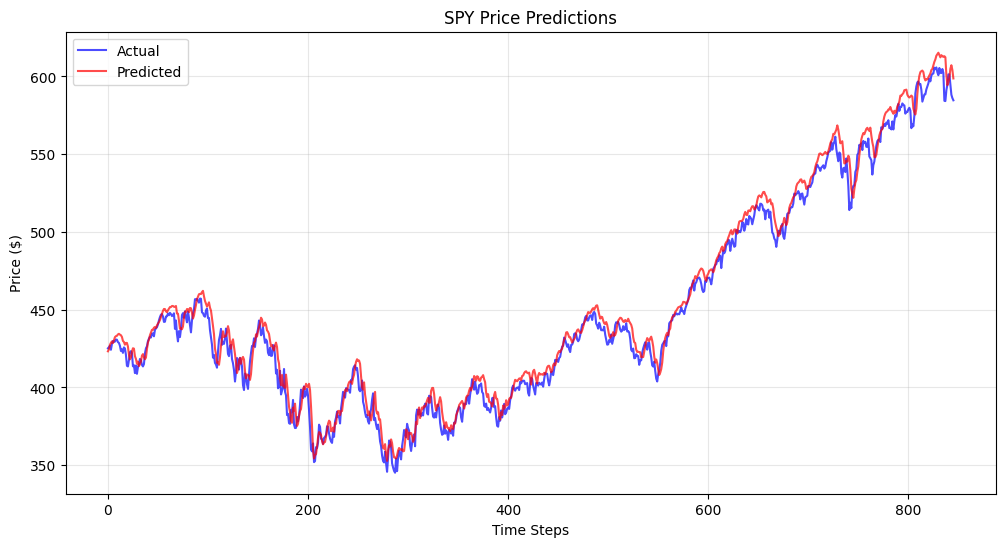


Prediction Statistics:
Mean Squared Error: 66.00
Mean Absolute Error: 6.38


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


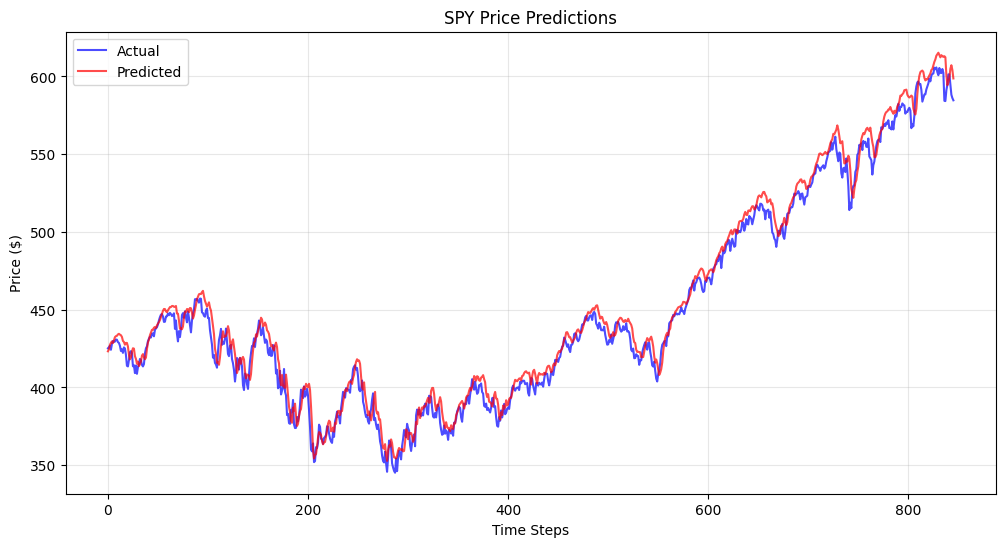


Prediction Statistics:
Mean Squared Error: 66.00
Mean Absolute Error: 6.38


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

In [ ]:
def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/pruned_model43.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/pruned_model43.keras"

    pruned = load_model(file_path)

    pruned.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def reshape_and_remake_layer(original_layer, target_shape):
    """
    Reshape and trim the number of neurons in a layer based on a target shape.

    Args:
        original_layer: The original layer with weights.
        target_shape: Tuple specifying the new shape (e.g., 4 neurons).

    Returns:
        A new layer with the specified shape.
    """
    # Extract weights from the original layer
    original_weights = original_layer.get_weights()

    if not original_weights:
        raise ValueError("The layer has no weights to reshape.")

    # Assume first array in weights is the main weight matrix
    main_weights = original_weights[0]  # Shape: (input_dim, output_dim)
    bias_weights = original_weights[1]  # Shape: (output_dim,)
    print(target_shape)
    # Trim weights to match the target shape
    new_output_dim = target_shape[-1]
    trimmed_weights = main_weights[:, :new_output_dim]
    trimmed_bias = bias_weights[:new_output_dim]
    print()
    # Create a new Dense layer with the target shape
    input_dim = main_weights.shape[0]
    new_layer = layers.Dense(new_output_dim)

    # Build the layer explicitly to initialize weights
    new_layer.build(input_shape=(-1, input_dim))

    # Set trimmed weights to the new layer
    new_layer.set_weights([trimmed_weights, trimmed_bias])

    return new_layer

# Example usage
if __name__ == "__main__":
    # Original model with 5 neurons in one layer
    model = models.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(5, activation='relu')
    ])

    print("Original Model Summary:")
    model.summary()

    # Extract the original layer
    print(model.layers[0].get_weights())
    original_layer = model.layers[0]  # Make sure it's a valid layer object
    if hasattr(original_layer, 'get_weights'):
        original_weights = original_layer.get_weights()
    else:
        print("This layer does not have weights.")

    # Reshape the layer to have 4 neurons instead of 5
    new_layer = reshape_and_remake_layer(original_layer, target_shape=(4,))

    # Build a new model with the reshaped layer
    new_model = models.Sequential([
        layers.Input(shape=(1,)),
        new_layer
    ])

    print("\nNew Model Summary:")
    new_model.summary()
    print(new_model.layers[0].get_weights())


Original Model Summary:


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                     │ (None, 5)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

[array([[-0.5920596 ,  0.42023802,  0.9662094 , -0.7531223 ,  0.39245033]],
      dtype=float32), array([0., 0., 0., 0., 0.], dtype=float32)]
(4,)


New Model Summary:


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                     │ (None, 4)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

[array([[-0.5920596 ,  0.42023802,  0.9662094 , -0.7531223 ]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]



Starting layer analysis...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Analyzing Original Model:
Layer Information:

Layer 0: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten (Flatten)

Layer 2: dense (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_1 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 2: dense

Weight Statistics:
mean: -0.0046
std: 0.1173
min: -0.8745
max: 0.5444
sparsity: 0.0000
total_weights: 8,400
nonzero_weights: 8,400
bias_mean: -0.0011
bias_std: 0.0184
bias_nonzero: 119

Weight Count Statistics:
Original weights: 8,400 total, 8,400 non-zero (100.00%)
After filtering: 8,400 total, 6,720 non-zero (80.00%)
Removed 1,680 weights (20.00% of non-zero weights)


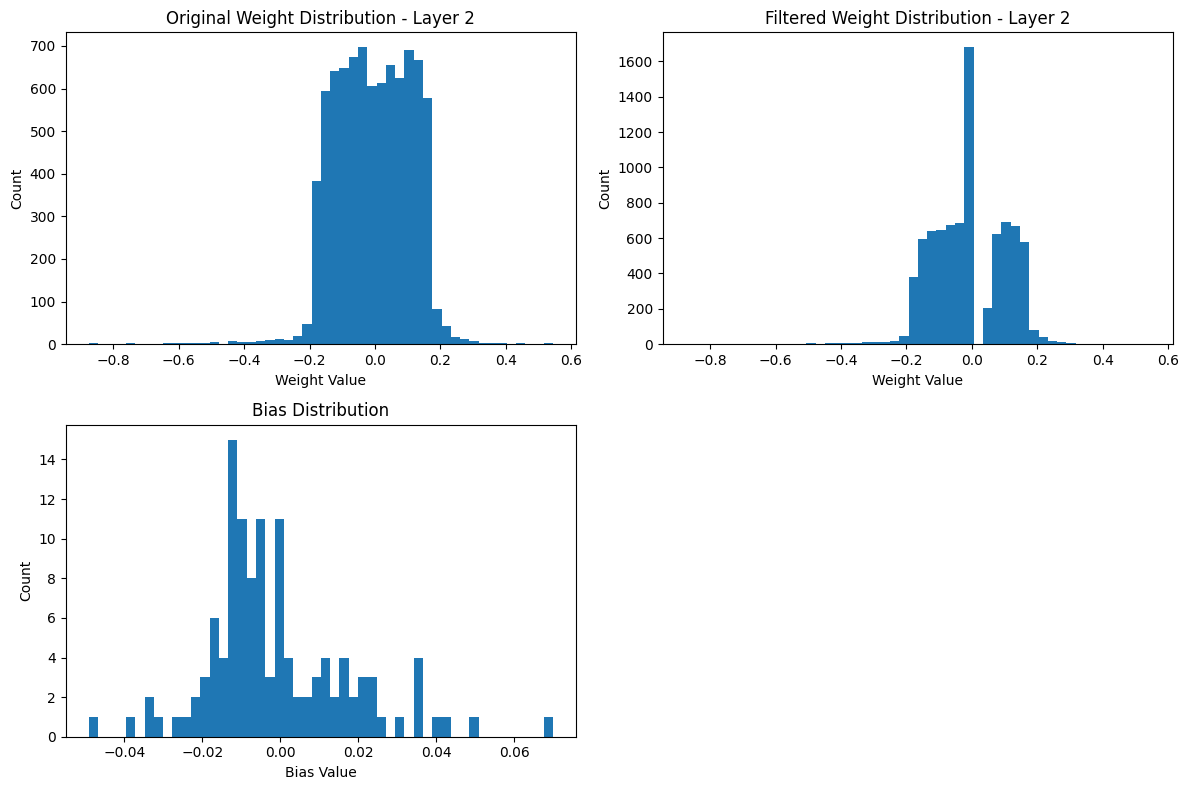


Analyzing Layer 3: dense_1

Weight Statistics:
mean: -0.0363
std: 0.2014
min: -0.7613
max: 1.1543
sparsity: 0.0000
total_weights: 120
nonzero_weights: 120
bias_mean: 0.0367
bias_std: 0.0000
bias_nonzero: 1

Weight Count Statistics:
Original weights: 120 total, 120 non-zero (100.00%)
After filtering: 120 total, 96 non-zero (80.00%)
Removed 24 weights (20.00% of non-zero weights)


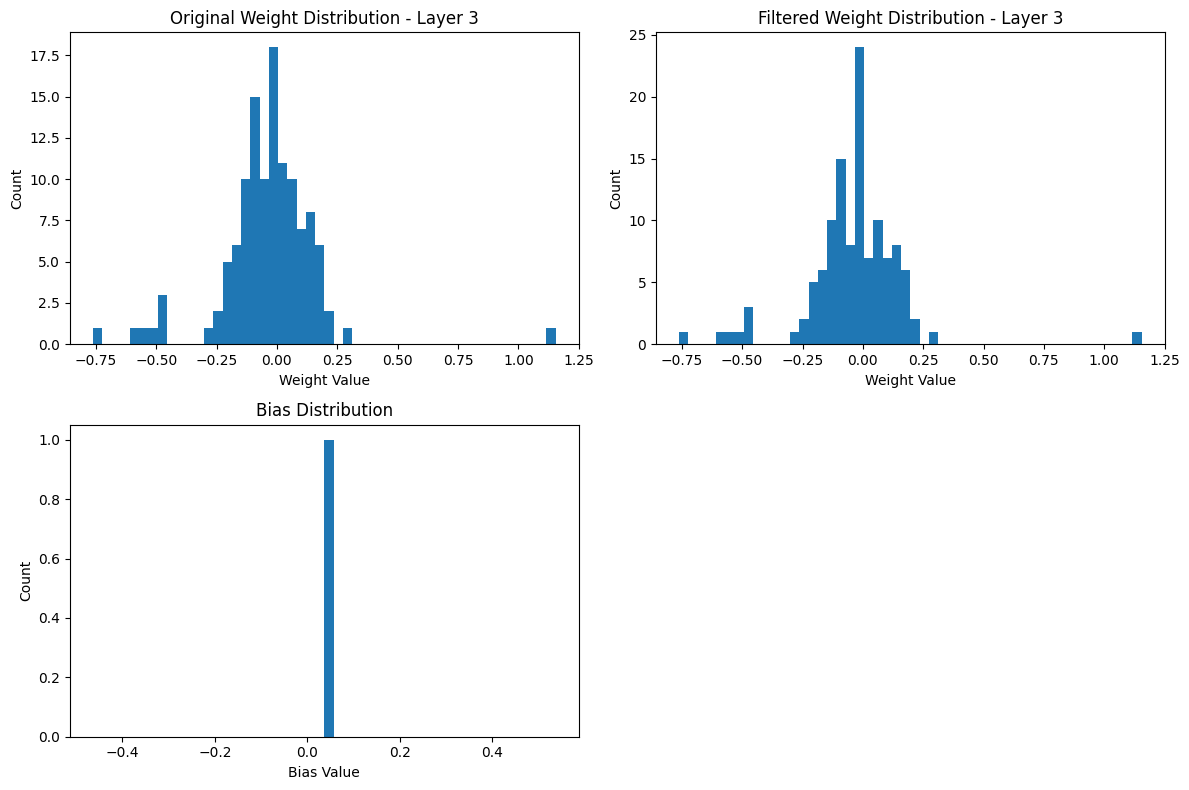


Revised Model Summary:


Model: "functional_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_72 (InputLayer)          │ (None, 14, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)


Model Comparison:

Layer 3:
Original units: 1
Revised units: 120
Reduction: -11900.0%

Total parameters reduction: 0.0%

Analyzing Revised Model:
Layer Information:

Layer 0: input_layer_72 (InputLayer)

Layer 1: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 2: flatten_15 (Flatten)

Layer 3: dense_84 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 4: dense_85 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 3: dense_84

Weight Statistics:
mean: -0.0077
std: 0.1165
min: -0.8745
max: 0.5444
sparsity: 0.2000
total_weights: 8,400
nonzero_weights: 6,720
bias_mean: -0.0011
bias_std: 0.0184
bias_nonzero: 119

Weight Count Statistics:
Original weights: 8,400 total, 6,720 non-zero (80.00%)
After filtering: 8,400 total, 6,720 non-zero (80.00%)
Removed 0 weights (0.00% of non-zero weights)


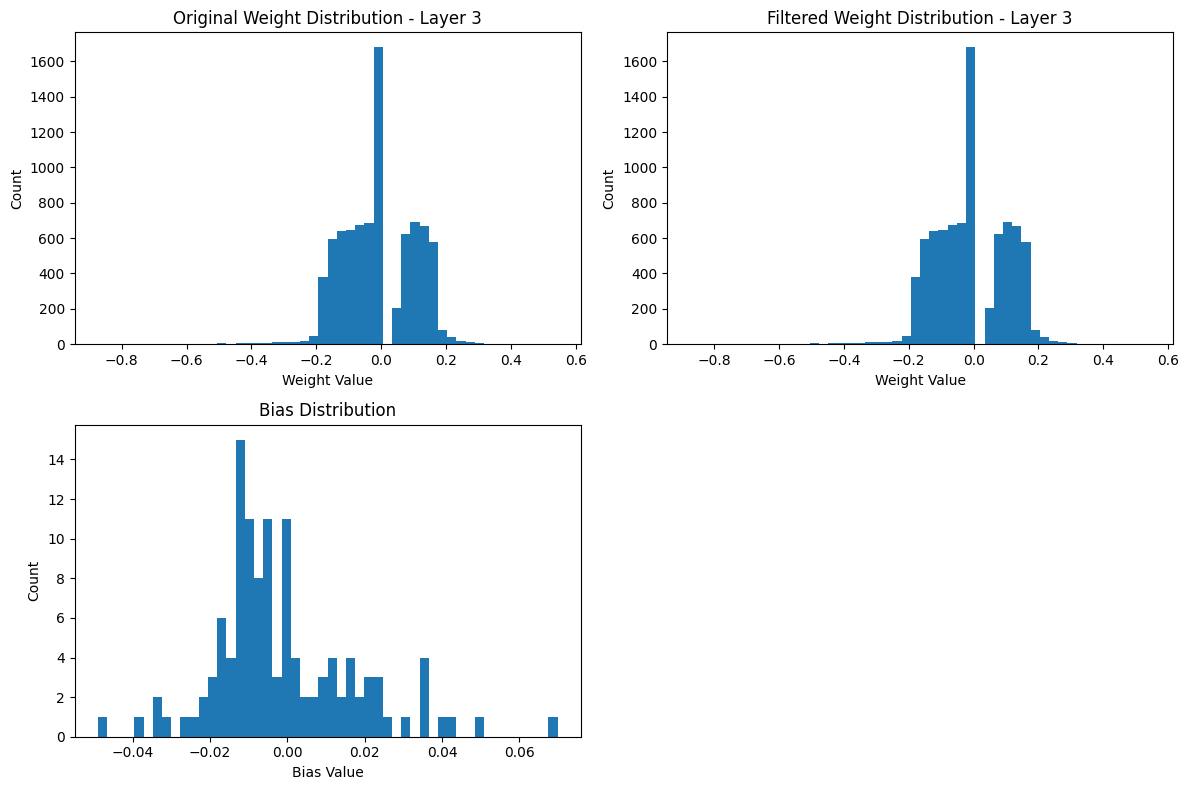


Analyzing Layer 4: dense_85

Weight Statistics:
mean: -0.0345
std: 0.2016
min: -0.7613
max: 1.1543
sparsity: 0.2000
total_weights: 120
nonzero_weights: 96
bias_mean: 0.0367
bias_std: 0.0000
bias_nonzero: 1

Weight Count Statistics:
Original weights: 120 total, 96 non-zero (80.00%)
After filtering: 120 total, 96 non-zero (80.00%)
Removed 0 weights (0.00% of non-zero weights)


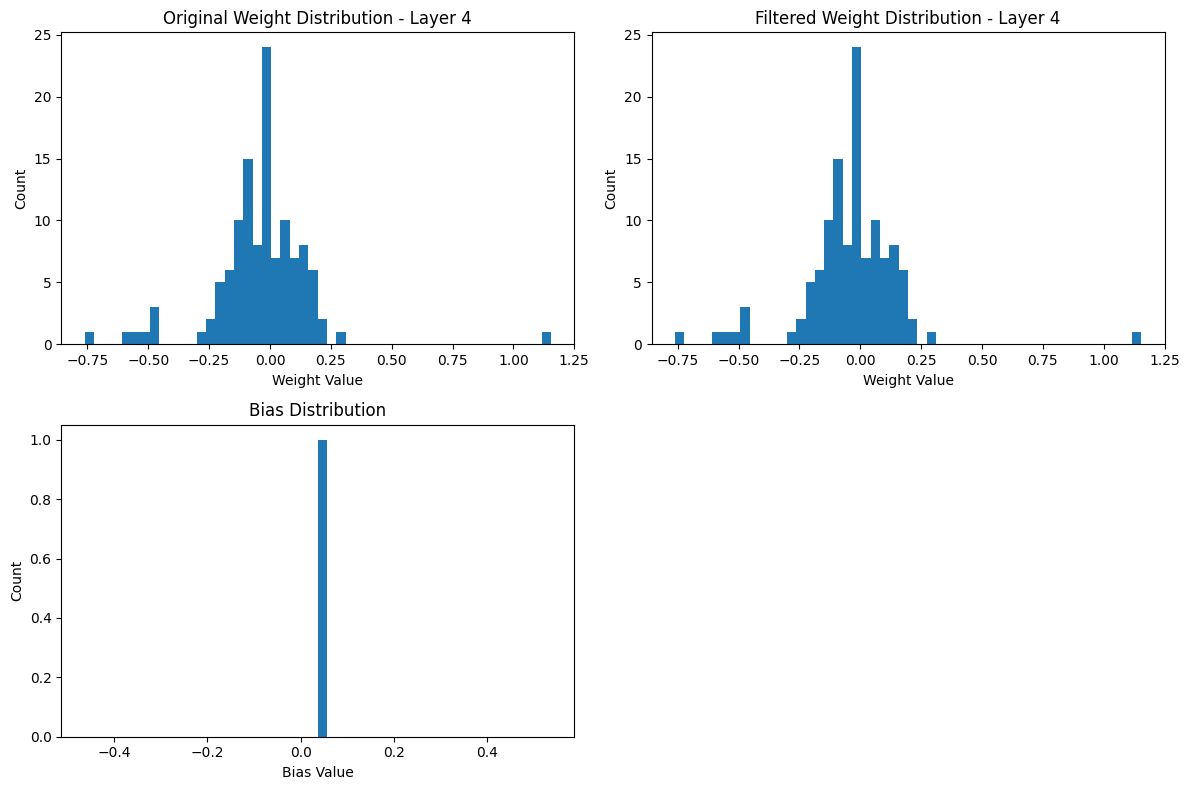

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import tensorflow as tf
from tensorflow.keras import layers

class SimpleLayerAnalyzer:
    def __init__(self, model):
        self.model = model
        self.filtered_weights = {}

    def print_layer_info(self):
        for i, layer in enumerate(self.model.layers):
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            weights = layer.get_weights()
            if weights:
                print(f"Number of weight arrays: {len(weights)}")
                for j, w in enumerate(weights):
                    print(f"Weight array {j} shape: {w.shape}")

    def analyze_weights(self, layer_index: int) -> Dict[str, np.ndarray]:
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        if not weights:
            return {}
        analysis = {}
        if len(weights) > 0:
            main_weights = weights[0]
            analysis['mean'] = np.mean(main_weights)
            analysis['std'] = np.std(main_weights)
            analysis['min'] = np.min(main_weights)
            analysis['max'] = np.max(main_weights)
            analysis['sparsity'] = np.mean(main_weights == 0)
            analysis['total_weights'] = main_weights.size
            analysis['nonzero_weights'] = np.count_nonzero(main_weights)
        if len(weights) > 1:
            bias = weights[1]
            analysis['bias_mean'] = np.mean(bias)
            analysis['bias_std'] = np.std(bias)
            analysis['bias_nonzero'] = np.count_nonzero(bias)
        return analysis

    def filter_weights(self, layer_index: int, stats: Dict[str, float]) -> List[np.ndarray]:
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        if not weights or not isinstance(layer, layers.Dense):
            return []
        filtered = []
        main_weights = weights[0]
        lower_percentile = np.percentile(main_weights, 45)
        upper_percentile = np.percentile(main_weights, 65)
        bottom_mask = (main_weights <= lower_percentile)
        top_mask = (main_weights > upper_percentile)
        combined_mask = bottom_mask | top_mask
        original_nonzero = np.count_nonzero(main_weights)
        original_total = main_weights.size
        filtered_weights = np.where(combined_mask, main_weights, 0)
        filtered_nonzero = np.count_nonzero(filtered_weights)
        print("\nWeight Count Statistics:")
        print(f"Original weights: {original_total:,} total, {original_nonzero:,} non-zero ({original_nonzero/original_total*100:.2f}%)")
        print(f"After filtering: {original_total:,} total, {filtered_nonzero:,} non-zero ({filtered_nonzero/original_total*100:.2f}%)")
        print(f"Removed {original_nonzero - filtered_nonzero:,} weights ({(original_nonzero - filtered_nonzero)/original_nonzero*100:.2f}% of non-zero weights)")
        filtered.append(filtered_weights)
        if len(weights) > 1:
            filtered.append(weights[1])
        return filtered

    def plot_weight_distribution(self, layer_index: int):
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        filtered = self.filtered_weights.get(layer_index, None)
        if not weights:
            print(f"Layer {layer_index} ({layer.name}) has no weights to plot")
            return
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f'Original Weight Distribution - Layer {layer_index}')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')
        if filtered is not None:
            plt.subplot(2, 2, 2)
            plt.hist(filtered[0].flatten(), bins=50)
            plt.title(f'Filtered Weight Distribution - Layer {layer_index}')
            plt.xlabel('Weight Value')
            plt.ylabel('Count')
        if len(weights) > 1:
            plt.subplot(2, 2, 3)
            plt.hist(weights[1].flatten(), bins=50)
            plt.title('Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

def create_revised_model(original_model, filtered_weights: Dict[int, List[np.ndarray]]) -> tf.keras.Model:
    new_layers = []
    input_shape = original_model.input_shape[1:]
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for layer_idx, layer in enumerate(original_model.layers):
        if isinstance(layer, layers.Dense) and layer_idx in filtered_weights:
            weights = filtered_weights[layer_idx]
            if not weights:
                continue
            main_weights = weights[0]
            nonzero_mask = np.any(main_weights != 0, axis=0)
            units = np.sum(nonzero_mask)

            new_weights = main_weights[:, nonzero_mask]
            new_bias = weights[1][nonzero_mask] if len(weights) > 1 else None
            new_layer = layers.Dense(
                units=units,
                activation=layer.activation,
                use_bias=layer.use_bias
            )
            new_layer.build((None, x.shape[-1]))
            if new_bias is not None:
                new_layer.set_weights([new_weights, new_bias])
            else:
                new_layer.set_weights([new_weights])
            x = new_layer(x)
        else:
            # Handle non-Dense layers directly
            if isinstance(layer, layers.Flatten):
                x = layers.Flatten()(x)
            elif isinstance(layer, layers.Dropout):
                x = layers.Dropout(layer.rate)(x)
            elif isinstance(layer, layers.BatchNormalization):
                x = layers.BatchNormalization()(x)
            else:
                # Copy the layer configuration
                config = layer.get_config()
                new_layer = layer.__class__.from_config(config)
                x = new_layer(x)

    revised_model = tf.keras.Model(inputs=inputs, outputs=x)

    # Copy compilation settings if available
    if hasattr(original_model, 'optimizer') and original_model.optimizer is not None:
        revised_model.compile(
            optimizer=original_model.optimizer.__class__.__name__,
            loss=original_model.loss,
            metrics=original_model.metrics
        )

    return revised_model

def analyze_model_revision(original_model, revised_model):
    print("\nModel Comparison:")
    total_params_original = original_model.count_params()
    total_params_revised = revised_model.count_params()

    for i, (orig_layer, rev_layer) in enumerate(zip(original_model.layers, revised_model.layers)):
        if isinstance(orig_layer, layers.Dense) and isinstance(rev_layer, layers.Dense):
            orig_weights = orig_layer.get_weights()
            rev_weights = rev_layer.get_weights()
            if orig_weights and rev_weights:
                orig_units = orig_weights[0].shape[-1]
                rev_units = rev_weights[0].shape[-1]
                reduction = (1 - rev_units/orig_units) * 100
                print(f"\nLayer {i}:")
                print(f"Original units: {orig_units:,}")
                print(f"Revised units: {rev_units:,}")
                print(f"Reduction: {reduction:.1f}%")

    total_reduction = (1 - total_params_revised/total_params_original) * 100
    print(f"\nTotal parameters reduction: {total_reduction:.1f}%")
    return revised_model

def analyze_model(model):
    analyzer = SimpleLayerAnalyzer(model)
    filtered_weights = {}
    print("Layer Information:")
    analyzer.print_layer_info()

    for i, layer in enumerate(model.layers):
        if isinstance(layer, layers.Dense) and layer.get_weights():
            print(f"\nAnalyzing Layer {i}: {layer.name}")
            stats = analyzer.analyze_weights(i)
            print("\nWeight Statistics:")
            for key, value in stats.items():
                if isinstance(value, (int, np.integer)):
                    print(f"{key}: {value:,}")
                else:
                    print(f"{key}: {value:.4f}")
            filtered = analyzer.filter_weights(i, stats)
            if filtered:
                filtered_weights[i] = filtered
                analyzer.filtered_weights[i] = filtered
            analyzer.plot_weight_distribution(i)
    return filtered_weights

if __name__ == "__main__":
    print("\nStarting layer analysis...")
    SPYModel1.summary()

    print("\nAnalyzing Original Model:")
    filtered_weights = analyze_model(SPYModel1)

    revised_model = create_revised_model(SPYModel1, filtered_weights)
    print("\nRevised Model Summary:")
    revised_model.summary()
    revised_model.save("revised_model.keras")
    analyze_model_revision(SPYModel1, revised_model)

    print("\nAnalyzing Revised Model:")
    analyze_model(revised_model)

[*********************100%***********************]  1 of 1 completed


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


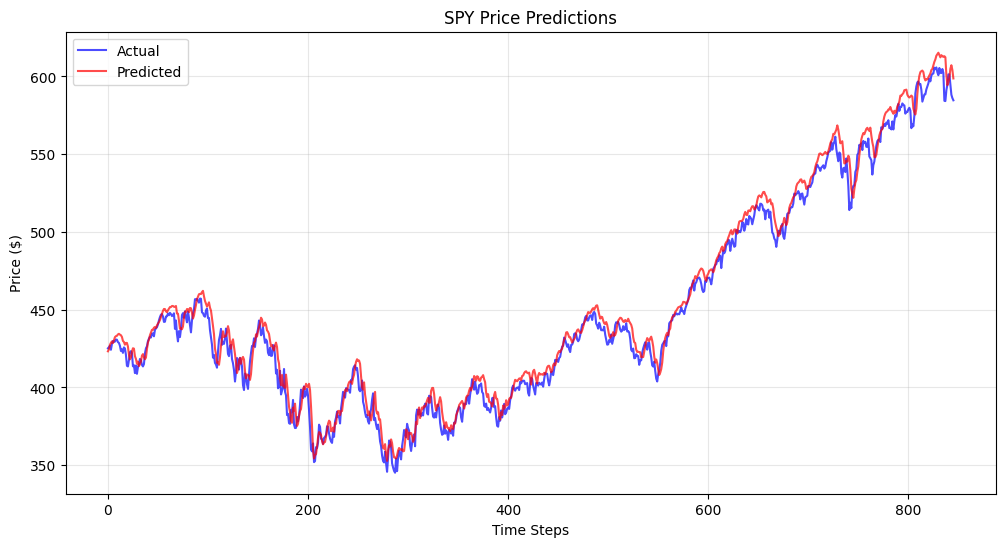


Prediction Statistics:
Mean Squared Error: 66.00
Mean Absolute Error: 6.38


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


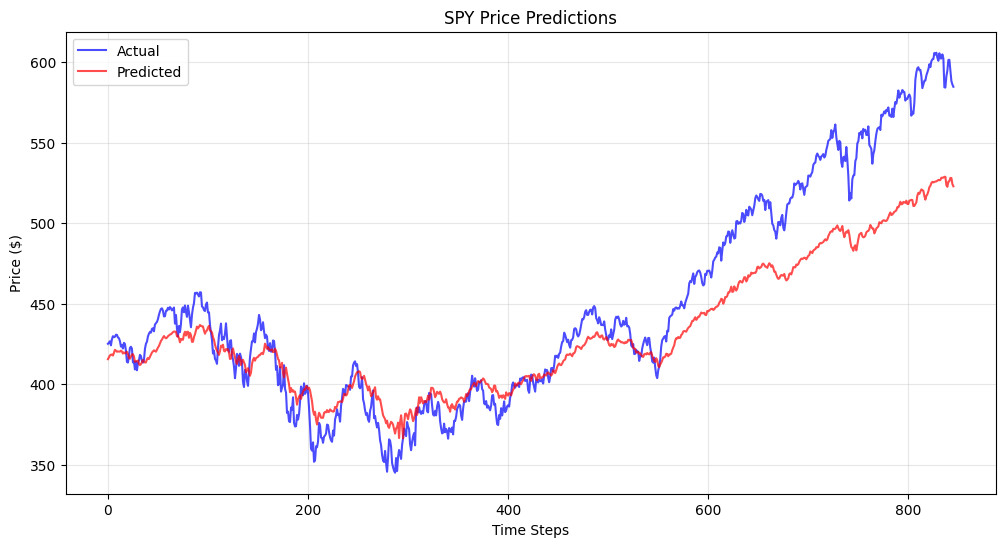


Prediction Statistics:
Mean Squared Error: 961.16
Mean Absolute Error: 22.61


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_71 (InputLayer)          │ (None, 14, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

In [ ]:
def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/revised_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/revised_model.keras"

    pruned = load_model(file_path)

    pruned.summary()